# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
import os
import openpyxl
import xlrd
from functools import reduce
import datetime

# Import Data Files

In [2]:
file = (r'c:/Users/pjant/Drew/DATA 601/datasets/final project/Dataset For Final Project.xlsm')
sheet_name = ('Data Table Training')

In [3]:
df_swapIV = pd.read_excel(file, sheet_name=sheet_name, header=1, names=('Date','IV'), usecols=(1,2))
df_swapRates = pd.read_excel(file, sheet_name=sheet_name, header=1, names=('Date','Rates'), usecols=(4,5) )
df_swapHV = pd.read_excel(file, sheet_name=sheet_name, header=1, names=('Date', 'HV'), usecols=(4,6))
df_VIX = pd.read_excel(file, sheet_name=sheet_name, header=1, names=('Date', 'VIX'), usecols=(8,9))
df_curve = pd.read_excel(file, sheet_name=sheet_name, header=1, names=('Date','Curve'), usecols=(11,12))
df_SPX = pd.read_excel(file, sheet_name=sheet_name, header=1, names=('Date','SPX'), usecols=(14,15))
df_SPXHV = pd.read_excel(file, sheet_name=sheet_name, header=1, names=('Date','SPXHV'), usecols=(14,16))
df_CDXHY = pd.read_excel(file, sheet_name=sheet_name, header=1, names=('Date','CDXHY'),usecols=(18,19))
df_Spreads = pd.read_excel(file, sheet_name=sheet_name, header=1, names=('Date','Spreads'),usecols=(21,22))
df_HYG = pd.read_excel(file, sheet_name=sheet_name, header=1, names=('Date','HYG'),usecols=(25,26))

# Create Data Frame

In [4]:
data_frames = [df_swapIV, df_swapRates, df_swapHV, df_VIX, df_curve, df_SPX, df_SPXHV, df_Spreads, df_HYG]

In [5]:
for i in data_frames:
    i = i.set_index('Date', inplace=True)

In [6]:
df = reduce(lambda  left,right:pd.merge(left,right,left_index=True,right_index=True),data_frames)

In [7]:
df = df.fillna(method='ffill')

# Examine Data

In [8]:
df.tail()

,IV,Rates,HV,VIX,Curve,SPX,SPXHV,Spreads,HYG
Date,,,,,,,,,
2020-05-04,60.0715,0.6306,0.299237,35.97,0.3149,2842.74,37.108482,-0.50,78.57
2020-05-05,60.5100,0.6569,0.353016,33.61,0.3443,2868.44,27.059637,-0.63,79.25
2020-05-06,63.1043,0.6667,0.355211,34.12,0.3705,2848.42,26.893851,-3.70,78.80
2020-05-07,64.3500,0.6080,0.612135,31.44,0.3655,2881.19,13.191213,-3.45,79.00
2020-05-08,67.0854,0.6439,0.689029,27.98,0.3877,2929.80,16.478790,-4.13,79.75


In [9]:
df.corr()

,IV,Rates,HV,VIX,Curve,SPX,SPXHV,Spreads,HYG
IV,1.000000,0.541449,0.629797,0.691381,0.476264,-0.686757,0.457121,0.558858,-0.318423
Rates,0.541449,1.000000,0.317200,0.211060,0.377279,-0.450918,0.085519,0.767881,0.221007
HV,0.629797,0.317200,1.000000,0.535655,0.200965,-0.329845,0.335355,0.384450,-0.218470
VIX,0.691381,0.211060,0.535655,1.000000,0.111117,-0.351626,0.541694,0.348368,-0.589274
Curve,0.476264,0.377279,0.200965,0.111117,1.000000,-0.814518,0.080334,0.246273,0.203589
SPX,-0.686757,-0.450918,-0.329845,-0.351626,-0.814518,1.000000,-0.287596,-0.454896,-0.072456
SPXHV,0.457121,0.085519,0.335355,0.541694,0.080334,-0.287596,1.000000,0.162575,-0.427341
Spreads,0.558858,0.767881,0.384450,0.348368,0.246273,-0.454896,0.162575,1.000000,0.335792
HYG,-0.318423,0.221007,-0.218470,-0.589274,0.203589,-0.072456,-0.427341,0.335792,1.000000


In [10]:
df.describe()

,IV,Rates,HV,VIX,Curve,SPX,SPXHV,Spreads,HYG
count,3155.000000,3155.000000,3155.000000,3155.000000,3155.000000,3155.000000,3155.000000,3155.000000,3155.000000
mean,91.200008,2.676806,0.840449,19.855242,1.301129,1830.225861,16.082987,11.027556,87.981991
std,31.738341,0.887146,0.546901,9.973338,0.816969,643.555423,14.942173,20.242569,6.083703
min,48.506900,0.608000,0.050724,9.140000,-0.132500,676.530000,0.806088,-18.000000,61.640000
25%,68.206750,2.065000,0.479298,13.545000,0.588300,1309.295000,7.275430,-1.625000,85.700000
50%,81.370000,2.532600,0.711944,16.850000,1.325500,1751.640000,11.912039,8.250000,88.000000
75%,107.530000,3.120150,1.031013,22.500000,2.002050,2280.875000,19.877469,14.750000,91.830000
max,212.650000,5.357000,5.464488,82.690000,2.806600,3386.150000,176.484818,91.290000,106.090000


C:\Users\pjant\Miniconda3\envs\data601\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


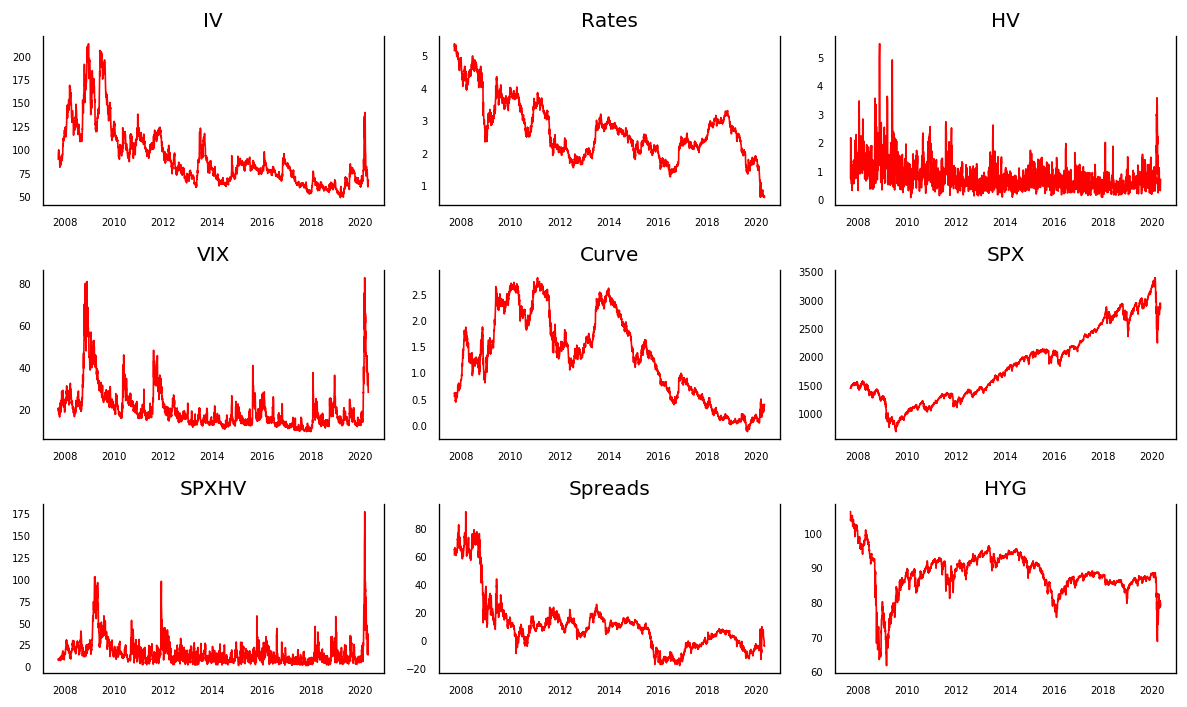

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=3, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    
plt.tight_layout()

In [12]:
df.isna().sum()

IV         0
Rates      0
HV         0
VIX        0
Curve      0
SPX        0
SPXHV      0
Spreads    0
HYG        0
dtype: int64

# Run a Lag Plot on the Raw Data

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

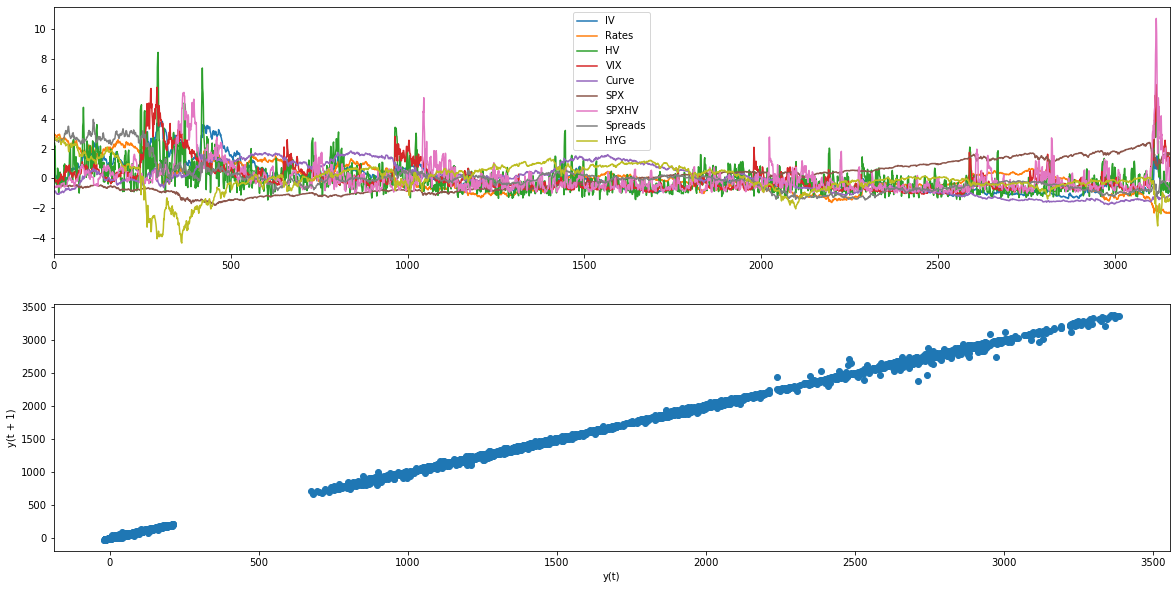

In [14]:
# Is the data Random.  Random data will not exhibit a structure in the lag plot

fig,(ax1,ax2)=plt.subplots(nrows=2, ncols=1, figsize=(20,10))
df_scaled.plot(ax=ax1) # series plot
pd.plotting.lag_plot(df) #lag plot

# Run Autocorrelation Plots on each of the Raw Variables for All Days in the Time Series

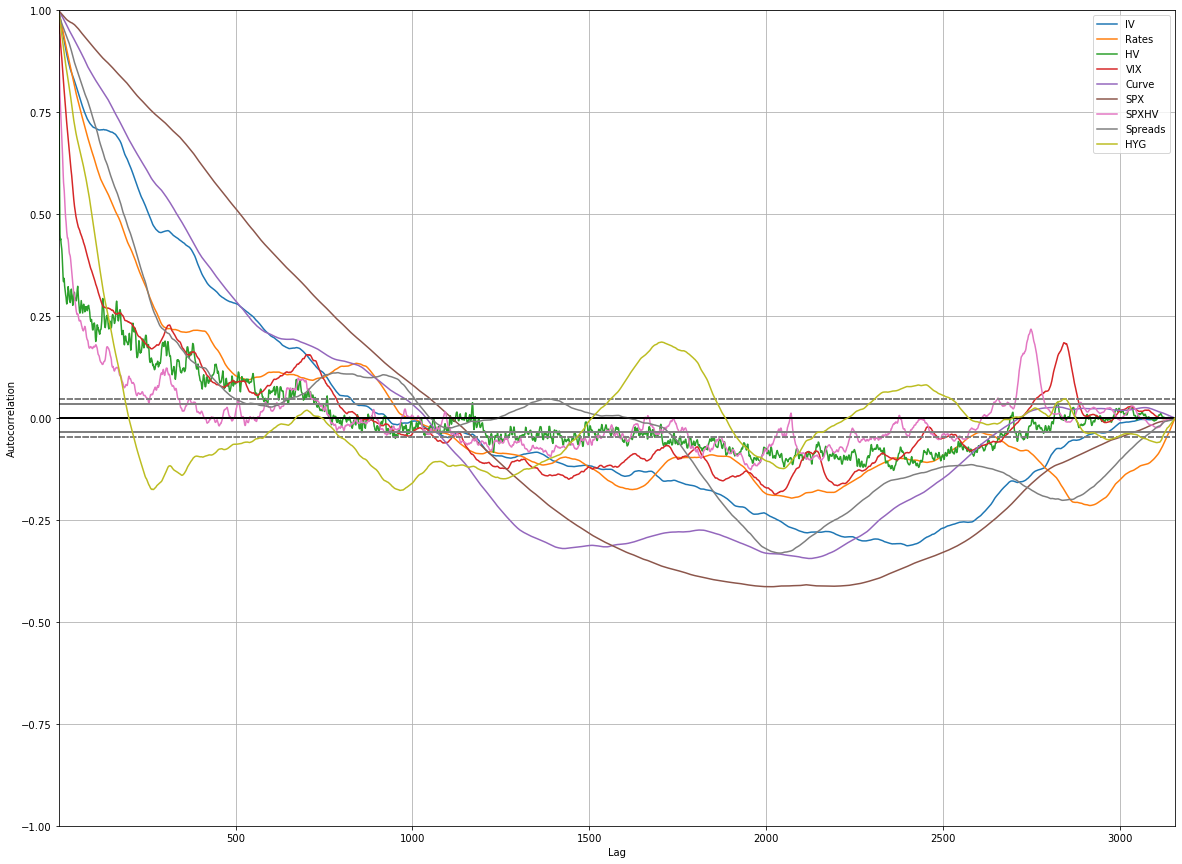

In [15]:
plt.rcParams["figure.figsize"] = (20,15)
pd.plotting.autocorrelation_plot(df.IV, label = 'IV')
pd.plotting.autocorrelation_plot(df.Rates, label = 'Rates')
pd.plotting.autocorrelation_plot(df.HV, label = 'HV')
pd.plotting.autocorrelation_plot(df.VIX, label = 'VIX')
pd.plotting.autocorrelation_plot(df.Curve, label = 'Curve')
pd.plotting.autocorrelation_plot(df.SPX, label = 'SPX')
pd.plotting.autocorrelation_plot(df.SPXHV, label = 'SPXHV')
pd.plotting.autocorrelation_plot(df.Spreads, label = 'Spreads')
pd.plotting.autocorrelation_plot(df.HYG, label = 'HYG')

# Run Autocorrelation and PACF plots for each raw variable for 75 days

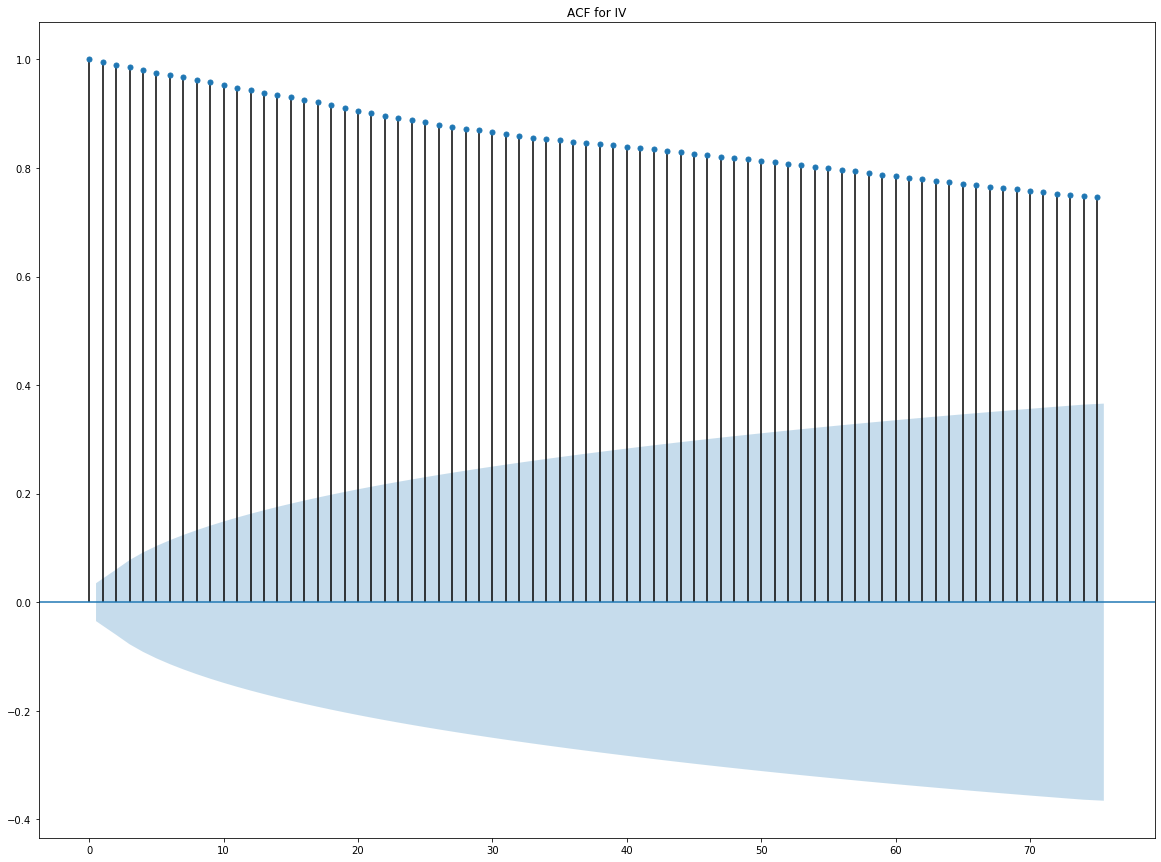

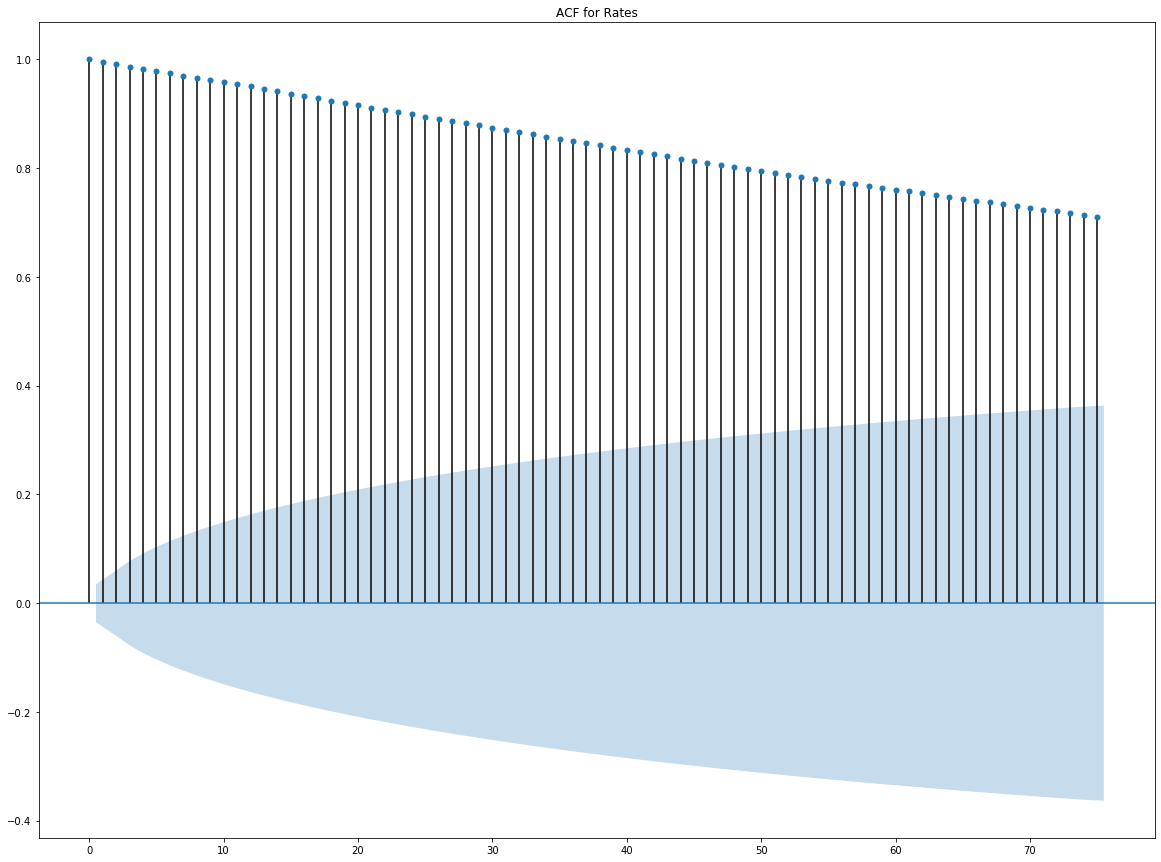

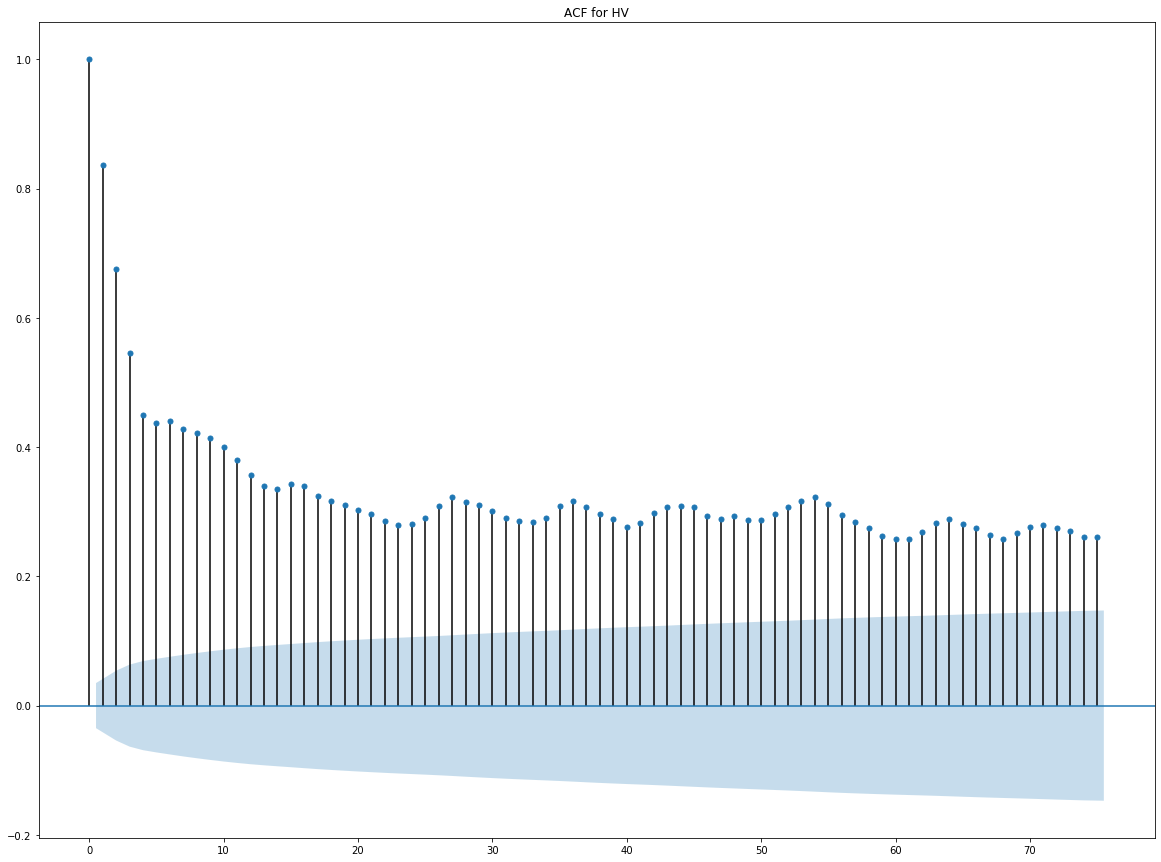

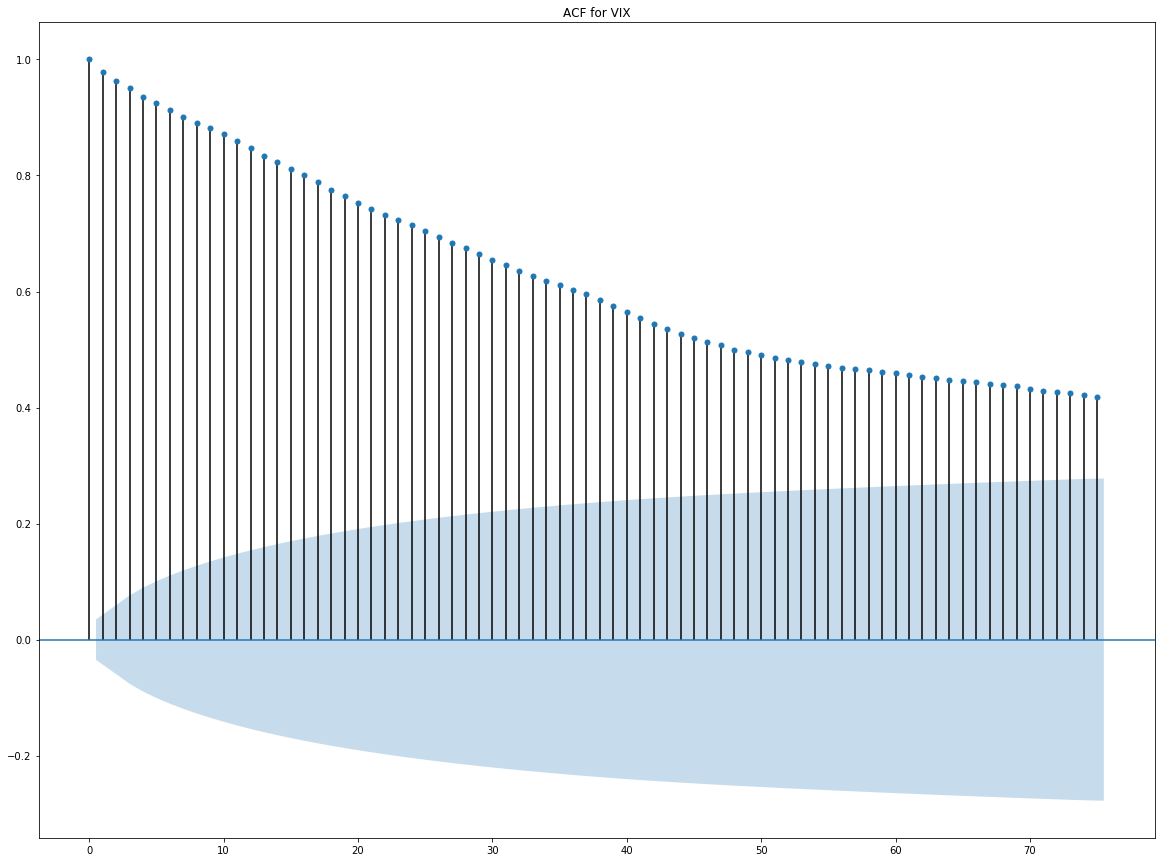

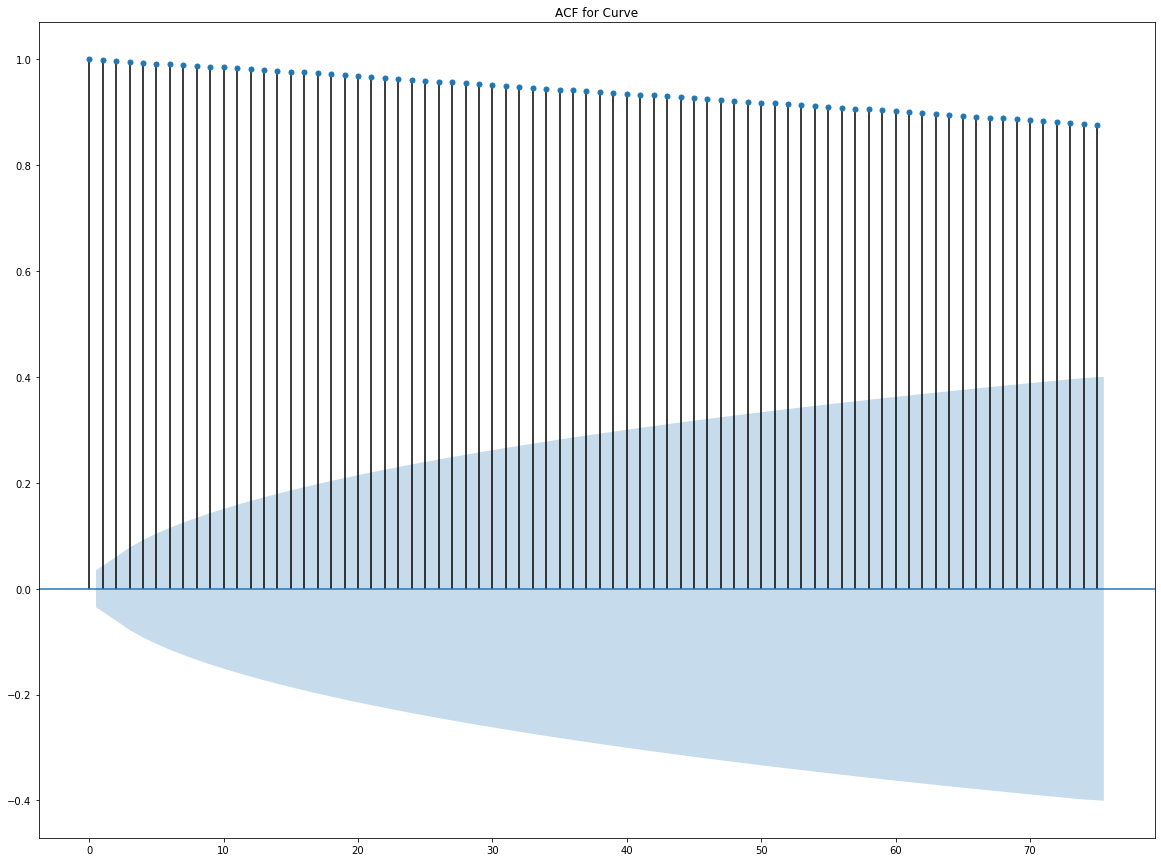

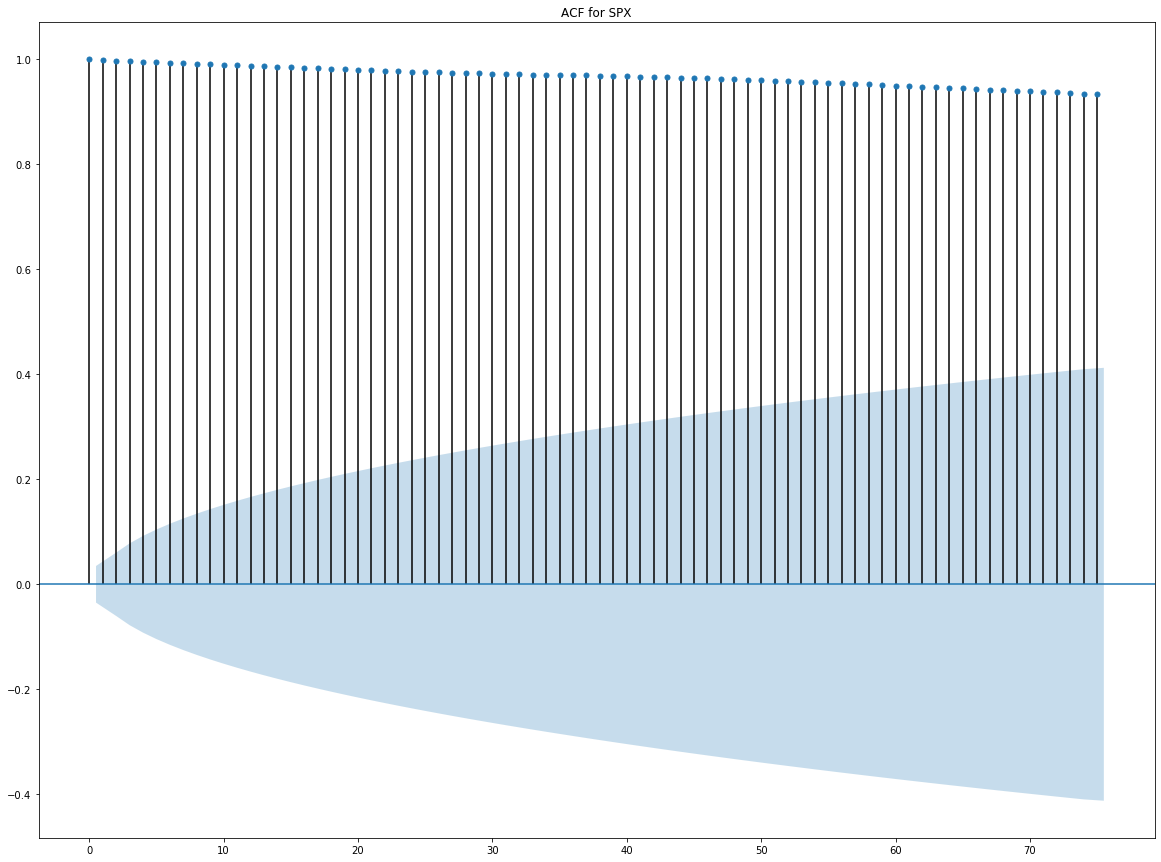

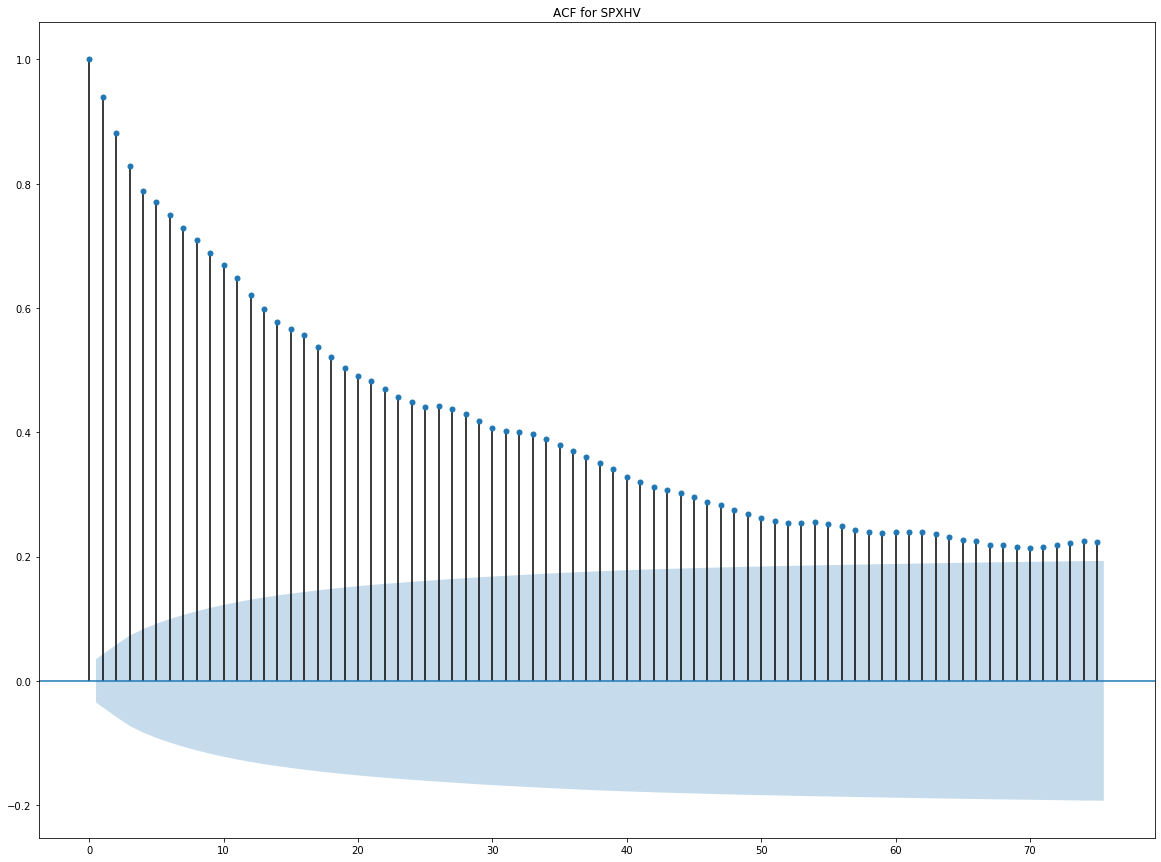

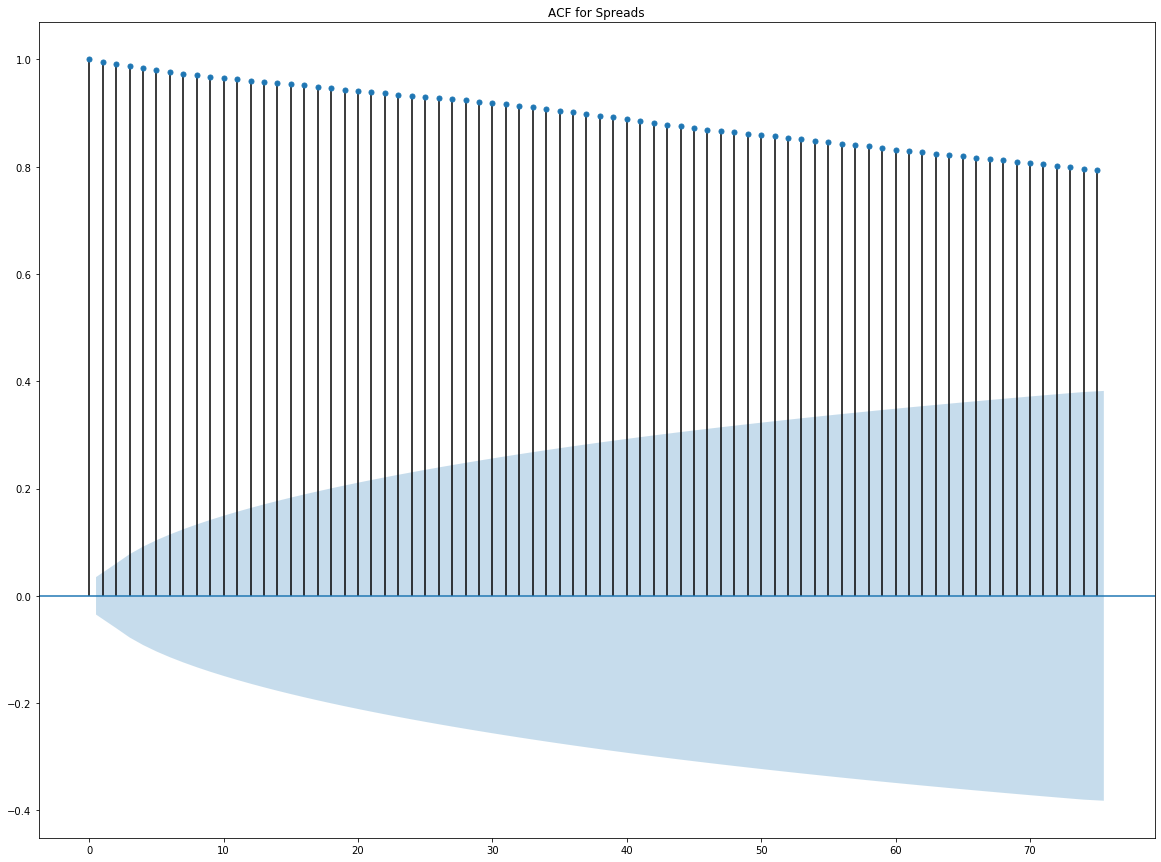

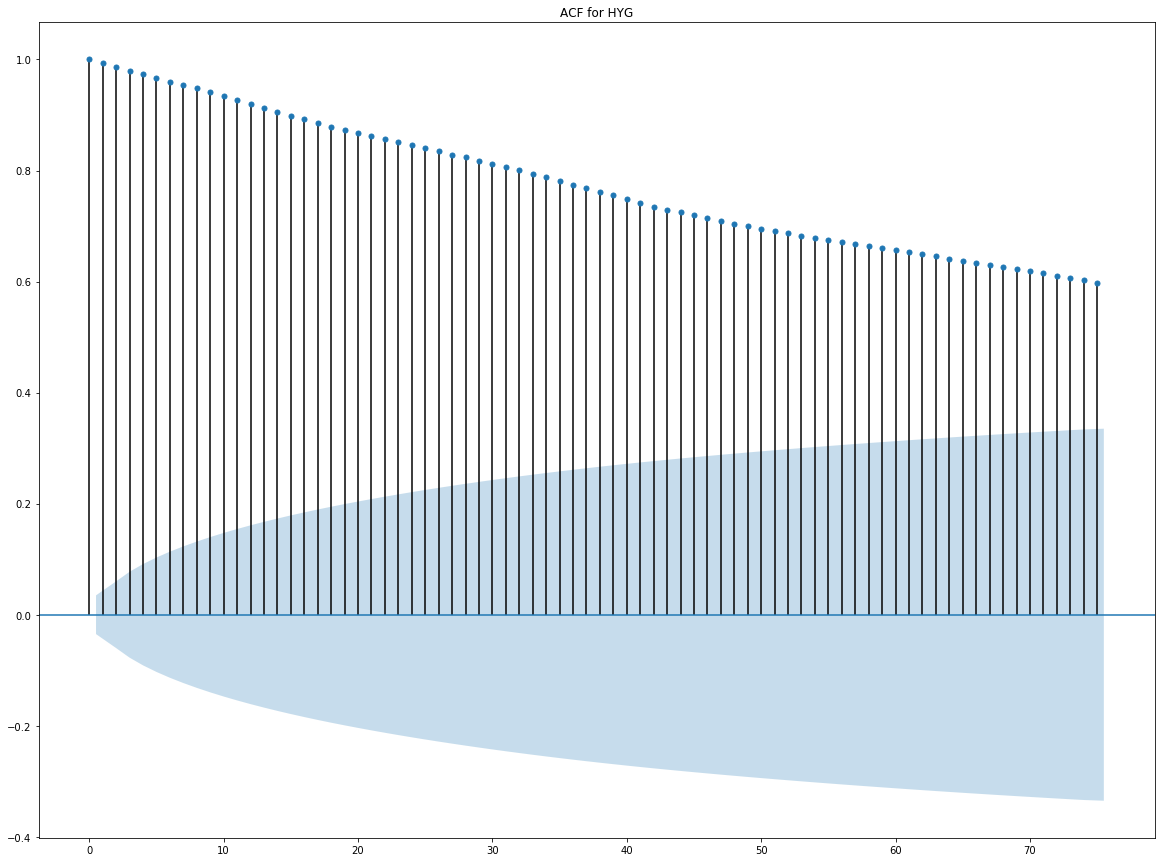

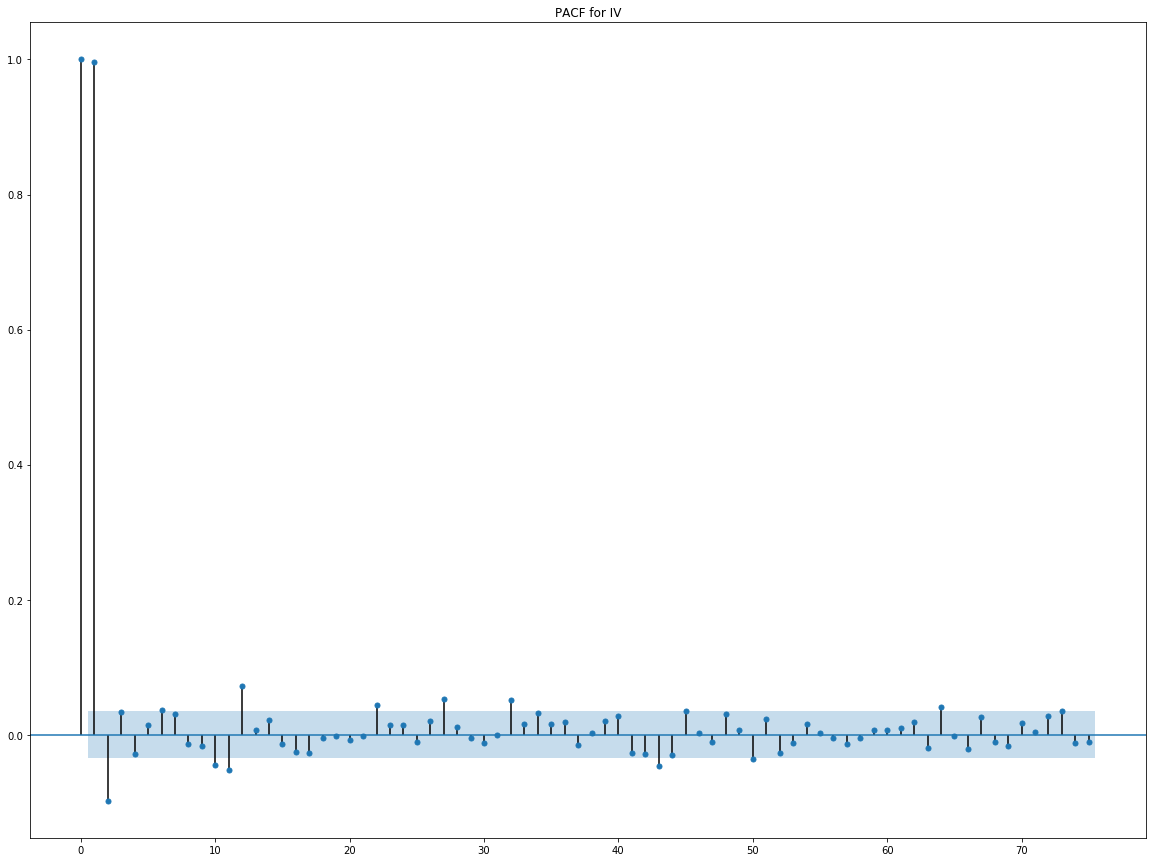

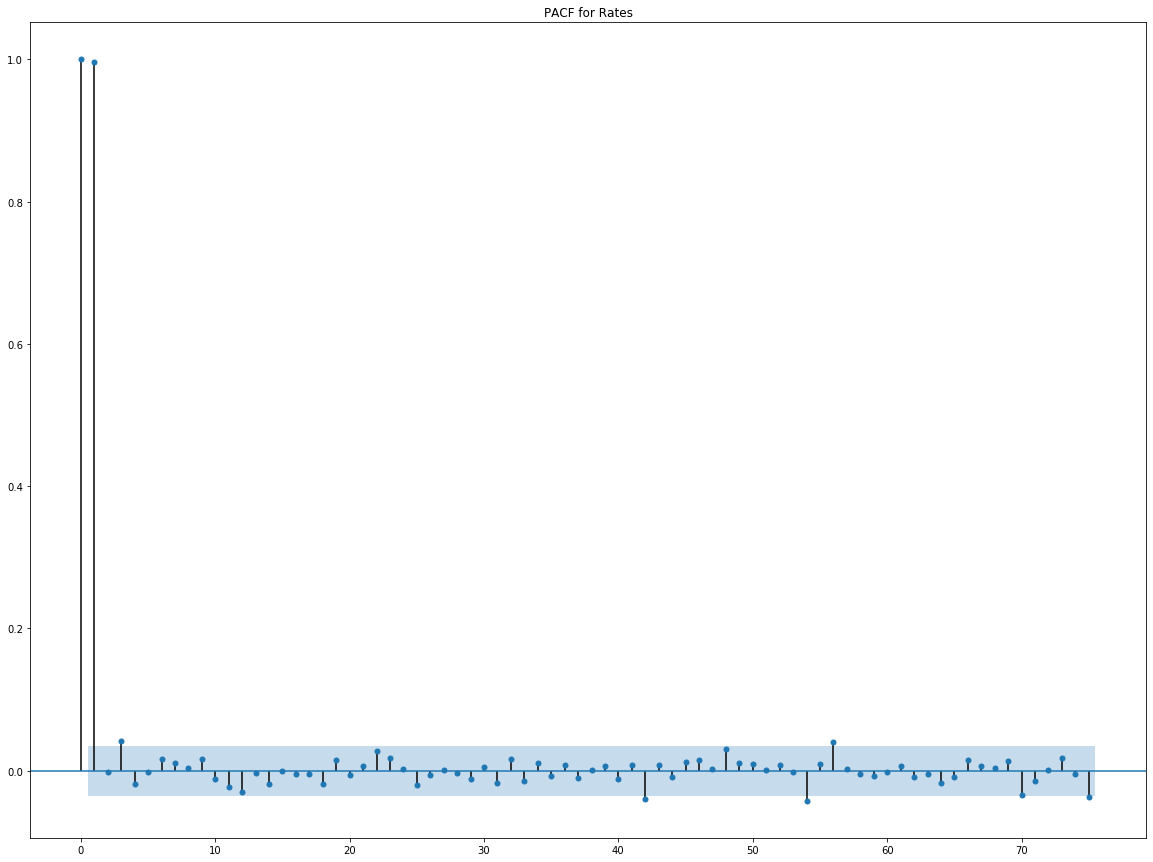

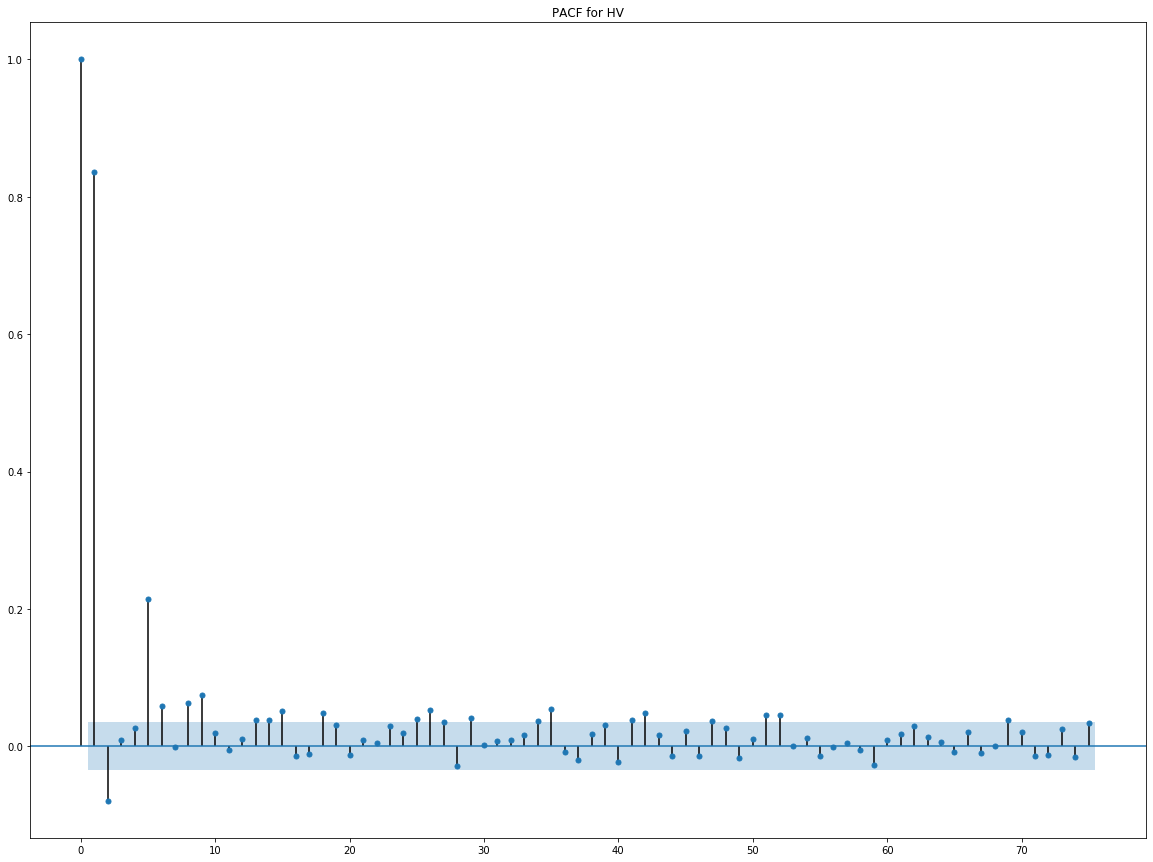

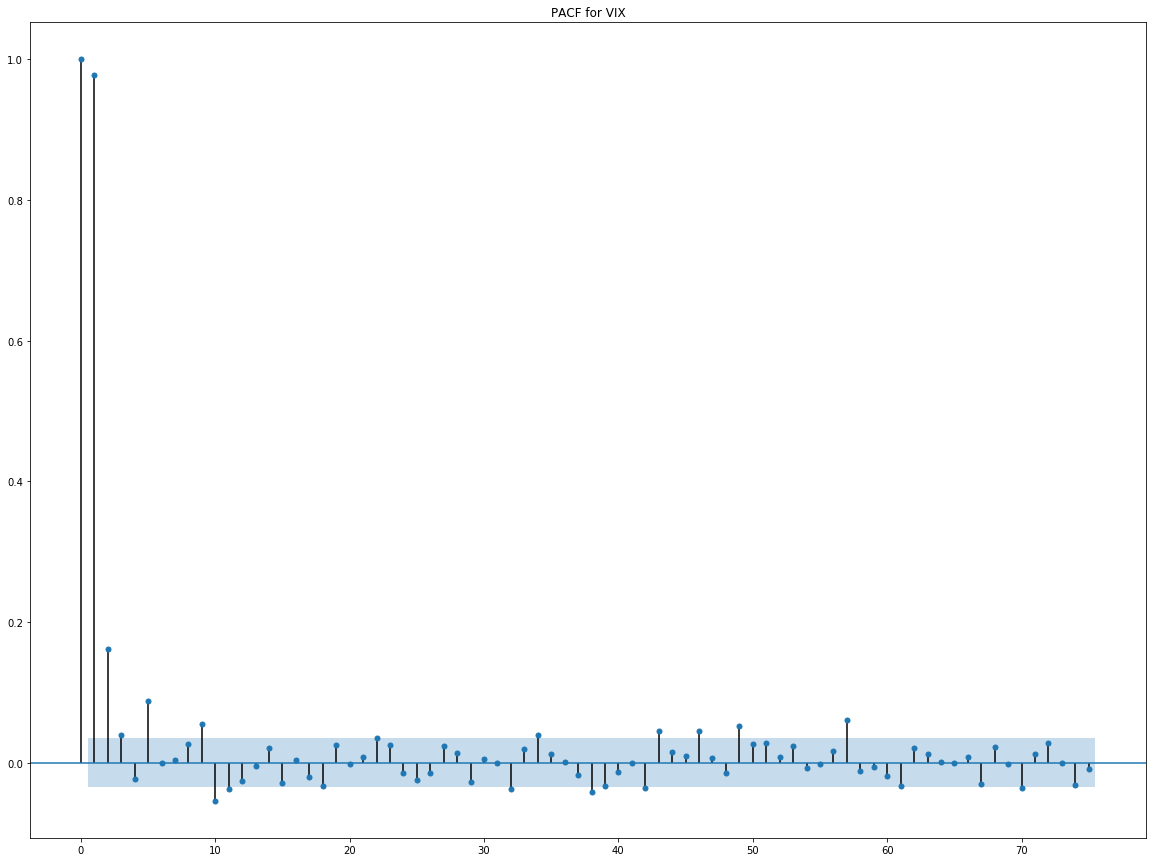

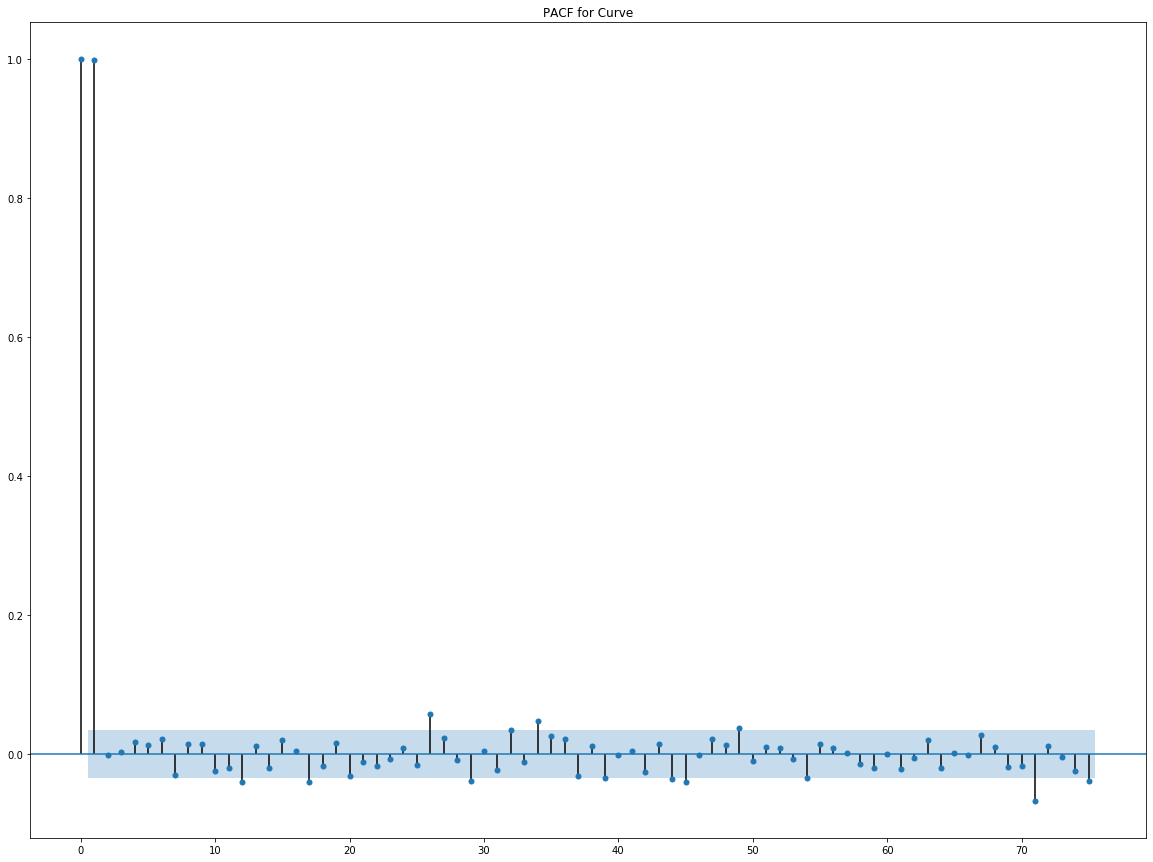

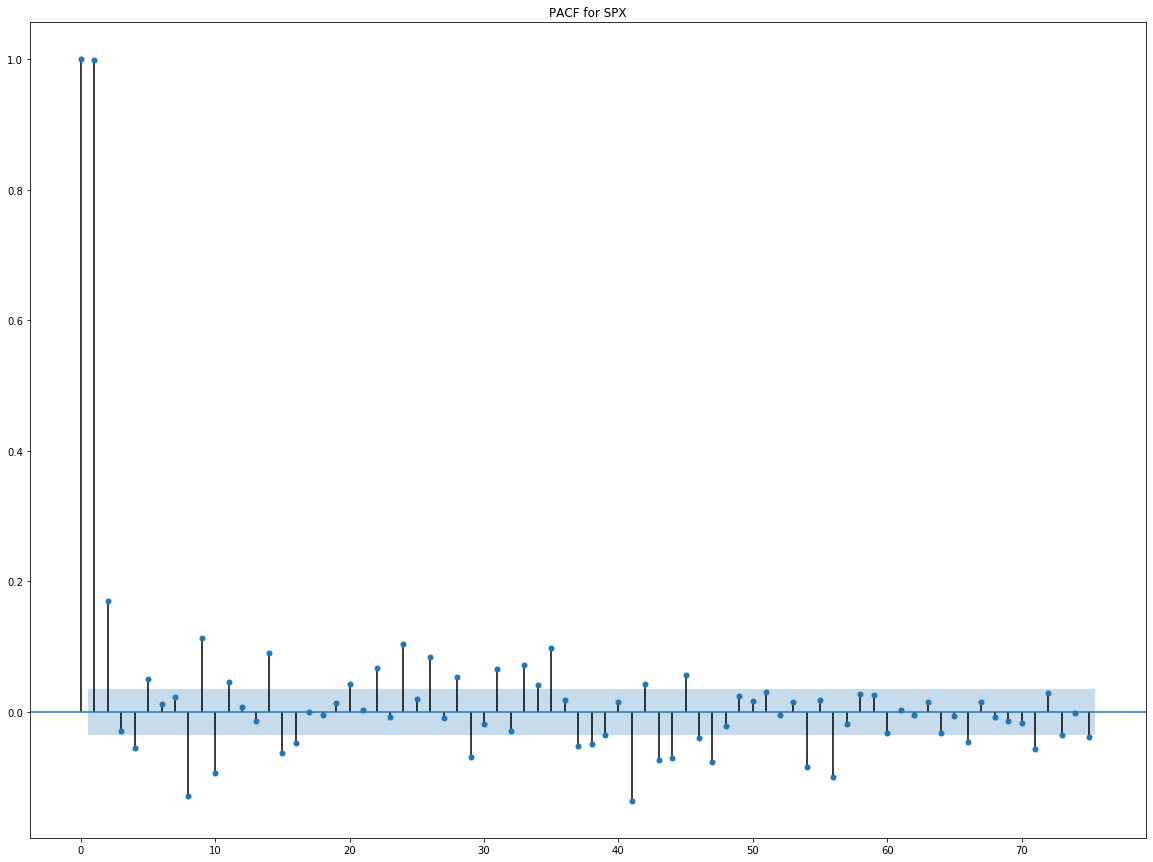

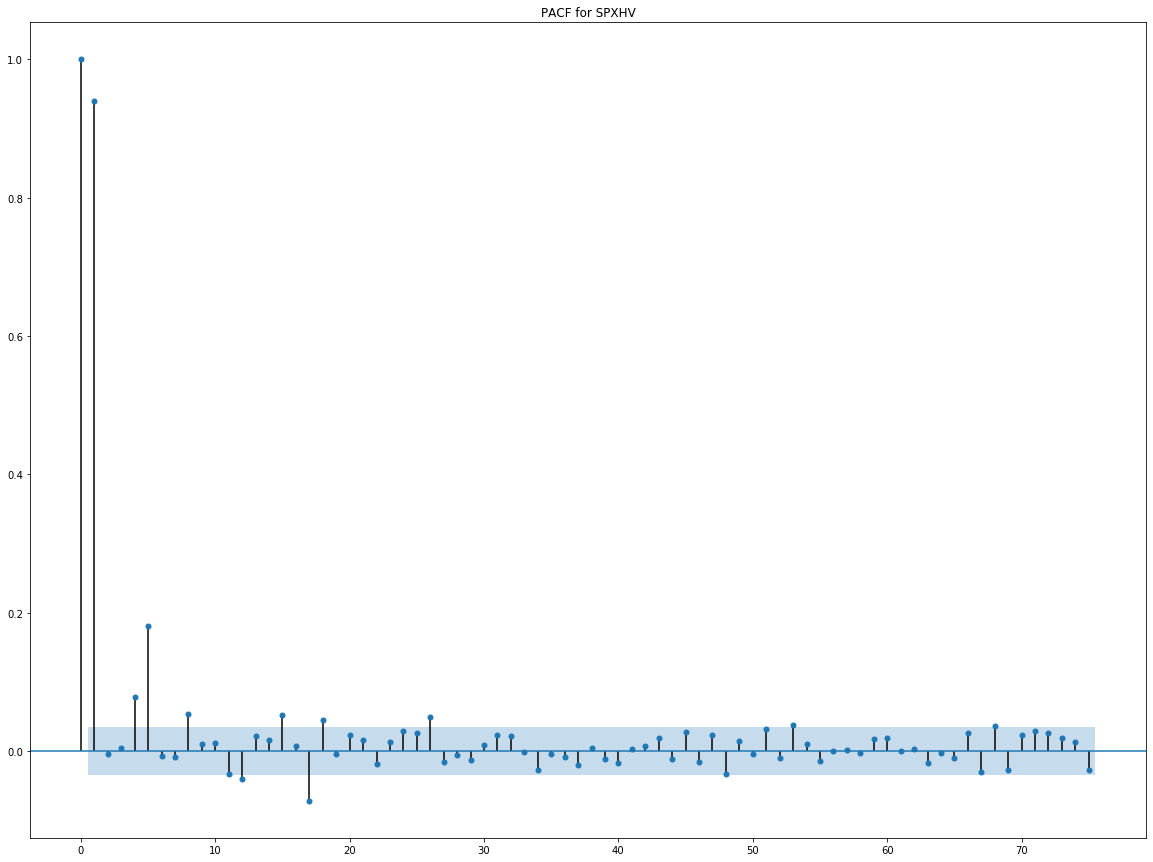

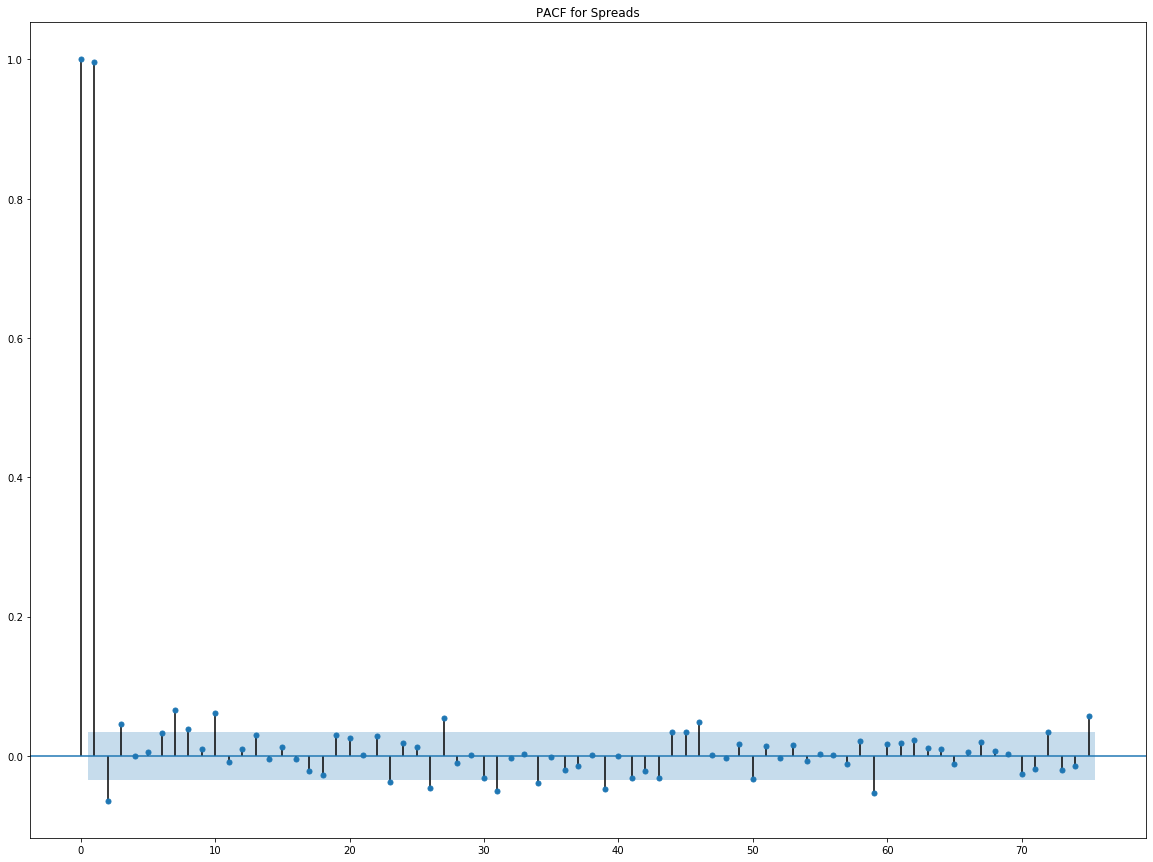

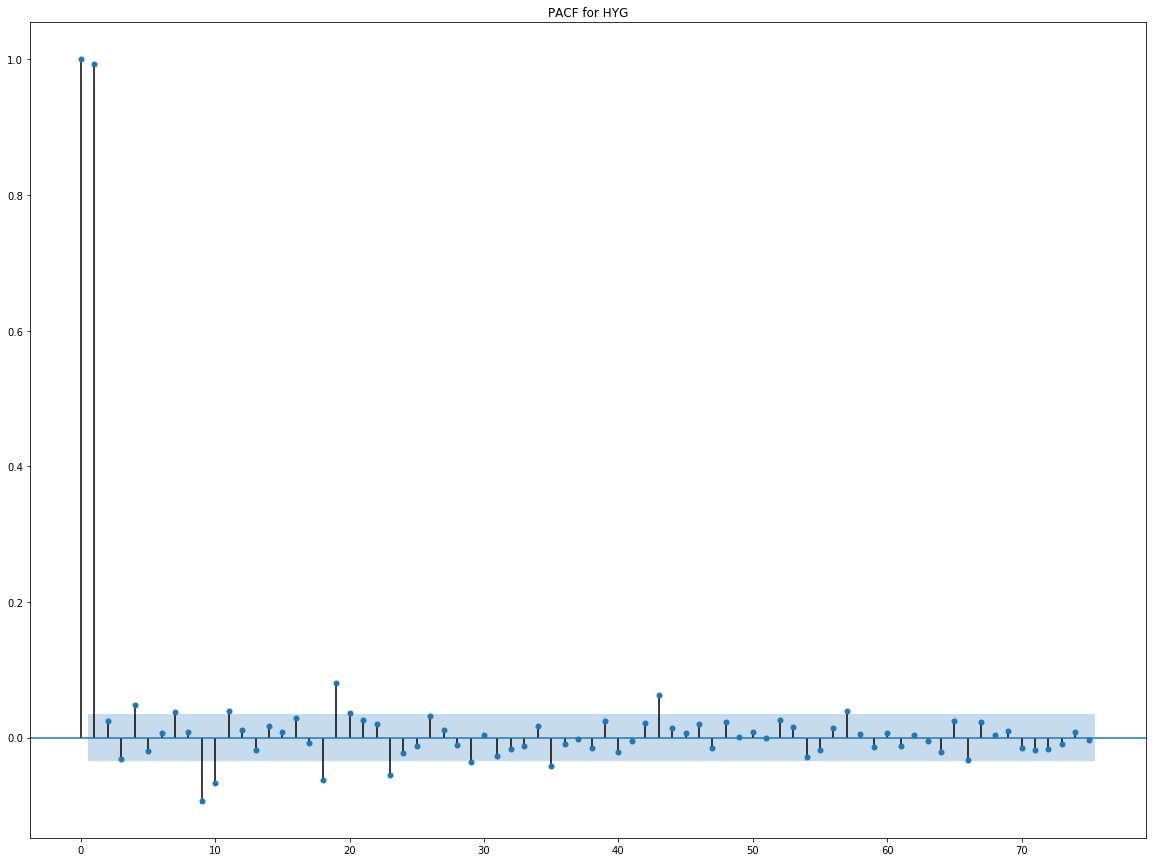

In [16]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

for i in df:
    plot_acf(df[i],lags=75)
    plt.title('ACF for %s'%i)
    
for j in df:
    plot_pacf(df[j], lags=75)
    plt.title('PACF for %s'%j)

# Run Granger Causality Tests on Every Raw Variable

The below block of code creates a function called 'grangers_causation_matrix', which runs each pair of columns against each other, n=maxlag times, and stores the minimum p-value for the given 'test' in a new 'column-by-column' dimension matrix

In [17]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df_granger = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df_granger.columns:
        for r in df_granger.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df_granger.loc[r, c] = min_p_value
    df_granger.columns = [var + '_x' for var in variables]
    df_granger.index = [var + '_y' for var in variables]
    return df_granger

grangers_causation_matrix(df, variables = df.columns)

# ran the block of code in detail - the below warning shows up (after making both of the above "verbose=True") at
# maxlag=10 for r='Spreads' and c='Spreads'

,IV_x,Rates_x,HV_x,VIX_x,Curve_x,SPX_x,SPXHV_x,Spreads_x,HYG_x
IV_y,1.0,0.0000,0.0001,0.0000,0.0196,0.2234,0.0000,0.0007,0.0000
Rates_y,0.0,1.0000,0.0006,0.0000,0.0018,0.0089,0.1311,0.0094,0.0094
HV_y,0.0,0.0000,1.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000
VIX_y,0.0,0.0006,0.0002,1.0000,0.0002,0.0000,0.0000,0.0000,0.0000
Curve_y,0.0,0.0113,0.0208,0.0022,1.0000,0.0001,0.0049,0.0004,0.0875
SPX_y,0.0,0.0931,0.0000,0.0000,0.0715,1.0000,0.0000,0.0014,0.0082
SPXHV_y,0.0,0.2529,0.0000,0.0000,0.4242,0.0000,1.0000,0.0215,0.0000
Spreads_y,0.0,0.0000,0.0011,0.0000,0.0003,0.0000,0.0018,1.0000,0.0000
HYG_y,0.0,0.1118,0.0001,0.0000,0.0014,0.0000,0.0017,0.0000,1.0000


Below code block is simply a copy and detailed explanation of each line of code for the 'grangers_causation_matrix' function created above

In [18]:
maxlag=12
test = 'ssr_chi2test'
variables = df.columns
verbose=False

#first, create a 'variable'-by-'variable' size dataframe filled with 0 values, with column names 'variables', 
# and indexes 'variables'
df_granger = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)

#run a granger causality test on each column v. each column in the original dataframe, and fill the above dataframe
#with the results
for c in df_granger.columns:  # for each column
    for r in df_granger.index: # begin with, and continue through, each row
        test_result = grangercausalitytests(df[[r, c]], maxlag=maxlag, verbose=False) #calculating the GCT - r is a column, and c is a different column
        p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)] #see note below for output of grangercausalitytests (here, 'test_result')
        if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
        min_p_value = np.min(p_values) #see note below
        df_granger.loc[r, c] = min_p_value #store the minimum p-value in the current r,c location of the new dataframe 
df_granger.columns = [var + '_x' for var in variables] #rename the column_heads as the x variables
df_granger.index = [var + '_y' for var in variables] #rename the row.indexes as the y variables
df_granger

#the output of the granger causality test is:
# 1) a dictionary of
# 2) n = maxlag results
# 3) each 2) above, or n, contains
# 4) 2 items
# 5) First, a dictionary of:
#   a) ssr_ftest: (1,2,3,4)
#   b) ssr_chi2test: (1,2,3)
#   c) lrtest: (1,2,3)
#   d) params_ftest
# 6) Second, 3 'results'
#   a) <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x18ea25b0198>
#   b) <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x18ea25b0668>
#   c) array([[0.,1.,0.]])
#As a result the code line above 'p_values = ...' pulls the 2nd number of the ssr_chi2test above for each of the maxlags,
#and then the 'min_p_value = ...' stores the minimum of these values for all of the maxlag runs

,IV_x,Rates_x,HV_x,VIX_x,Curve_x,SPX_x,SPXHV_x,Spreads_x,HYG_x
IV_y,1.0,0.0000,0.0001,0.0000,0.0196,0.2234,0.0000,0.0007,0.0000
Rates_y,0.0,1.0000,0.0006,0.0000,0.0018,0.0089,0.1311,0.0094,0.0094
HV_y,0.0,0.0000,1.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000
VIX_y,0.0,0.0006,0.0002,1.0000,0.0002,0.0000,0.0000,0.0000,0.0000
Curve_y,0.0,0.0113,0.0208,0.0022,1.0000,0.0001,0.0049,0.0004,0.0875
SPX_y,0.0,0.0931,0.0000,0.0000,0.0715,1.0000,0.0000,0.0014,0.0082
SPXHV_y,0.0,0.2529,0.0000,0.0000,0.4242,0.0000,1.0000,0.0215,0.0000
Spreads_y,0.0,0.0000,0.0011,0.0000,0.0003,0.0000,0.0018,1.0000,0.0000
HYG_y,0.0,0.1118,0.0001,0.0000,0.0014,0.0000,0.0017,0.0000,1.0000


The 2 code blocks below are simply a way to test each of the individual results in the above matrix for correctness.  Not necessary to run, just here in case of 'suspicious' values that need to be checked.

In [19]:
granger = grangercausalitytests(df[['HYG','IV']], maxlag=12, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9968  , p=0.3182  , df_denom=3151, df_num=1
ssr based chi2 test:   chi2=0.9977  , p=0.3179  , df=1
likelihood ratio test: chi2=0.9976  , p=0.3179  , df=1
parameter F test:         F=0.9968  , p=0.3182  , df_denom=3151, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9367  , p=0.0196  , df_denom=3148, df_num=2
ssr based chi2 test:   chi2=7.8860  , p=0.0194  , df=2
likelihood ratio test: chi2=7.8761  , p=0.0195  , df=2
parameter F test:         F=3.9367  , p=0.0196  , df_denom=3148, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3479  , p=0.0707  , df_denom=3145, df_num=3
ssr based chi2 test:   chi2=7.0595  , p=0.0700  , df=3
likelihood ratio test: chi2=7.0516  , p=0.0703  , df=3
parameter F test:         F=2.3479  , p=0.0707  , df_denom=3145, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7514  , p=0.

In [20]:
a = 0
b = 1

print(granger[1][a]['ssr_chi2test'][b])
print(granger[2][a]['ssr_chi2test'][b])
print(granger[3][a]['ssr_chi2test'][b])
print(granger[4][a]['ssr_chi2test'][b])
print(granger[5][a]['ssr_chi2test'][b])
print(granger[6][a]['ssr_chi2test'][b])
print(granger[7][a]['ssr_chi2test'][b])
print(granger[8][a]['ssr_chi2test'][b])
print(granger[9][a]['ssr_chi2test'][b])
print(granger[10][a]['ssr_chi2test'][b])
print(granger[11][a]['ssr_chi2test'][b])
print(granger[12][a]['ssr_chi2test'][b])

0.3178619280961153
0.01939037115627683
0.07002476236291855
0.13452872411329783
0.07542617984636844
0.12583621961034838
0.18422962861607386
0.21829571749370816
0.3590738229541289
0.014833053291293046
2.35545166367056e-06
2.8791803109864375e-06


# Run Cointegration Tests for Each of the Raw Variables

In [21]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
IV     ::  669.49    > 179.5199  =>   True
Rates  ::  318.29    > 143.6691  =>   True
HV     ::  182.62    > 111.7797  =>   True
VIX    ::  83.02     > 83.9383   =>   False
Curve  ::  53.21     > 60.0627   =>   False
SPX    ::  26.94     > 40.1749   =>   False
SPXHV  ::  11.28     > 24.2761   =>   False
Spreads ::  3.38      > 12.3212   =>   False
HYG    ::  0.04      > 4.1296    =>   False


# Run Dickey-Fuller Tests on the Raw Data to Check for Stationarity

In [22]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [23]:
# ADF Test on each column
for name, column in df.iteritems():      # changed this row of code - df_train to df
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "IV" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6675
 No. Lags Chosen       = 11
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0798. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Rates" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.237
 No. Lags Chosen       = 2
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.1931. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "HV" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root.

# Create Training and Testing Set on the Raw Data

In [24]:
nobs = 5
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(3150, 9)
(5, 9)


# Difference the Training Data (ADF Tests Did Not Look Good; also too much AC)

In [25]:
t = df_train.diff().dropna()

# Analyze the Differenced Data

In [26]:
t.tail()

,IV,Rates,HV,VIX,Curve,SPX,SPXHV,Spreads,HYG
Date,,,,,,,,,
2020-04-27,-5.6499,0.0463,0.154998,-2.64,0.0517,41.74,-4.700357,-1.25,0.32
2020-04-28,0.0399,-0.0551,0.200610,0.28,-0.0320,-15.09,2.739992,-0.85,0.24
2020-04-29,-1.7800,0.0145,0.001220,-2.34,0.0336,76.12,4.786682,0.10,1.39
2020-04-30,-1.5109,0.0072,-0.002095,2.92,0.0233,-27.08,5.982760,-0.50,0.16
2020-05-01,-3.7791,-0.0257,-0.167010,3.04,-0.0294,-81.72,9.544144,0.00,-1.75


In [27]:
t.corr()

,IV,Rates,HV,VIX,Curve,SPX,SPXHV,Spreads,HYG
IV,1.000000,0.152311,0.107833,0.238424,0.166429,-0.097281,-0.036607,0.178855,-0.203572
Rates,0.152311,1.000000,0.016272,-0.370704,0.675210,0.111439,-0.006411,0.216534,0.252167
HV,0.107833,0.016272,1.000000,0.021381,0.058427,-0.005943,0.001767,0.044193,-0.029262
VIX,0.238424,-0.370704,0.021381,1.000000,-0.257897,-0.206038,0.044610,0.100738,-0.575484
Curve,0.166429,0.675210,0.058427,-0.257897,1.000000,0.073802,0.008361,0.088378,0.195196
SPX,-0.097281,0.111439,-0.005943,-0.206038,0.073802,1.000000,0.015223,-0.025042,0.190300
SPXHV,-0.036607,-0.006411,0.001767,0.044610,0.008361,0.015223,1.000000,-0.046940,0.021212
Spreads,0.178855,0.216534,0.044193,0.100738,0.088378,-0.025042,-0.046940,1.000000,-0.074790
HYG,-0.203572,0.252167,-0.029262,-0.575484,0.195196,0.190300,0.021212,-0.074790,1.000000


In [28]:
t.describe()

,IV,Rates,HV,VIX,Curve,SPX,SPXHV,Spreads,HYG
count,3149.000000,3149.000000,3149.000000,3149.000000,3149.000000,3149.000000,3149.000000,3149.000000,3149.000000
mean,-0.009384,-0.001439,-0.000073,0.005449,-0.000079,0.440171,0.008935,-0.019127,-0.008704
std,2.923505,0.061798,0.313366,2.076906,0.040668,23.448583,5.187356,1.519240,0.628565
min,-20.150000,-0.441000,-2.774537,-17.640000,-0.322000,-324.890000,-45.733687,-13.500000,-6.980000
25%,-1.250000,-0.036800,-0.113088,-0.770000,-0.021500,-7.060000,-1.468611,-0.570000,-0.210000
50%,-0.108000,-0.002000,0.002343,-0.100000,-0.001500,1.120000,0.009233,0.000000,0.015000
75%,1.075000,0.034100,0.115248,0.590000,0.021100,9.610000,1.595643,0.510000,0.210000
max,32.180000,0.342500,2.558241,24.860000,0.254500,230.380000,55.719395,13.500000,8.365000


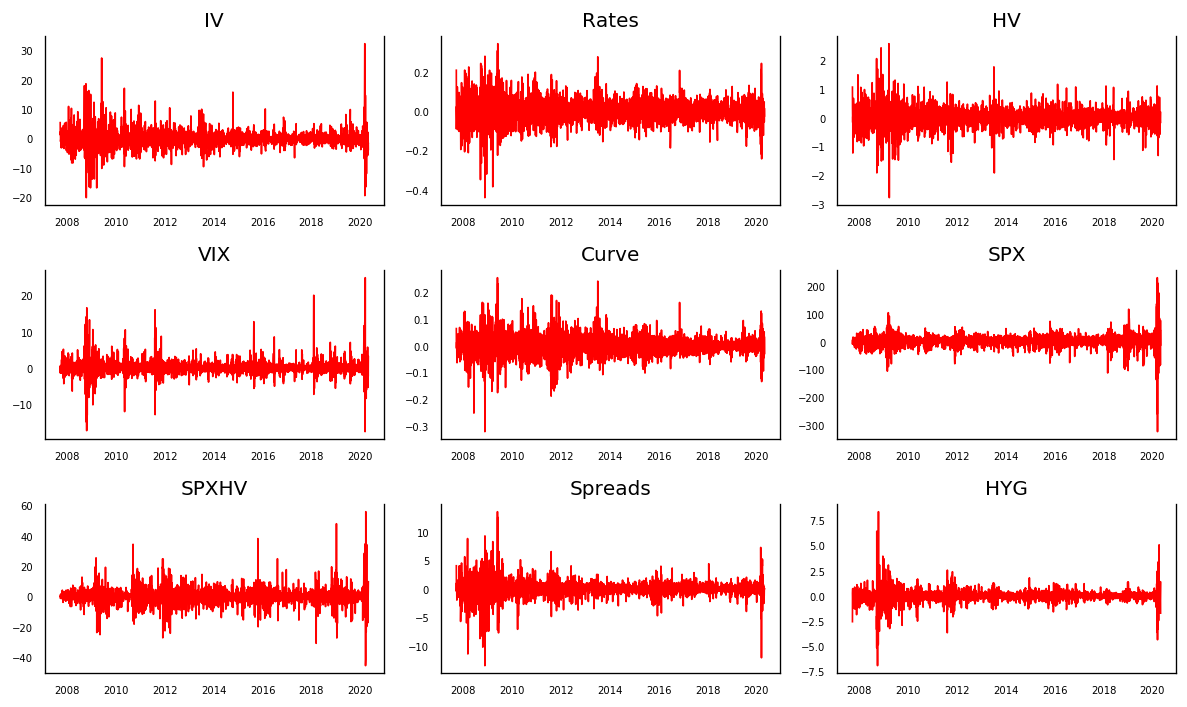

In [29]:
fig, axes = plt.subplots(nrows=3, ncols=3, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = t[t.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.set_title(t.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    
plt.tight_layout()

# Run a Lag Plot on the Differenced Data

In [30]:
t_scaled = pd.DataFrame(scaler.fit_transform(t), columns = t.columns)

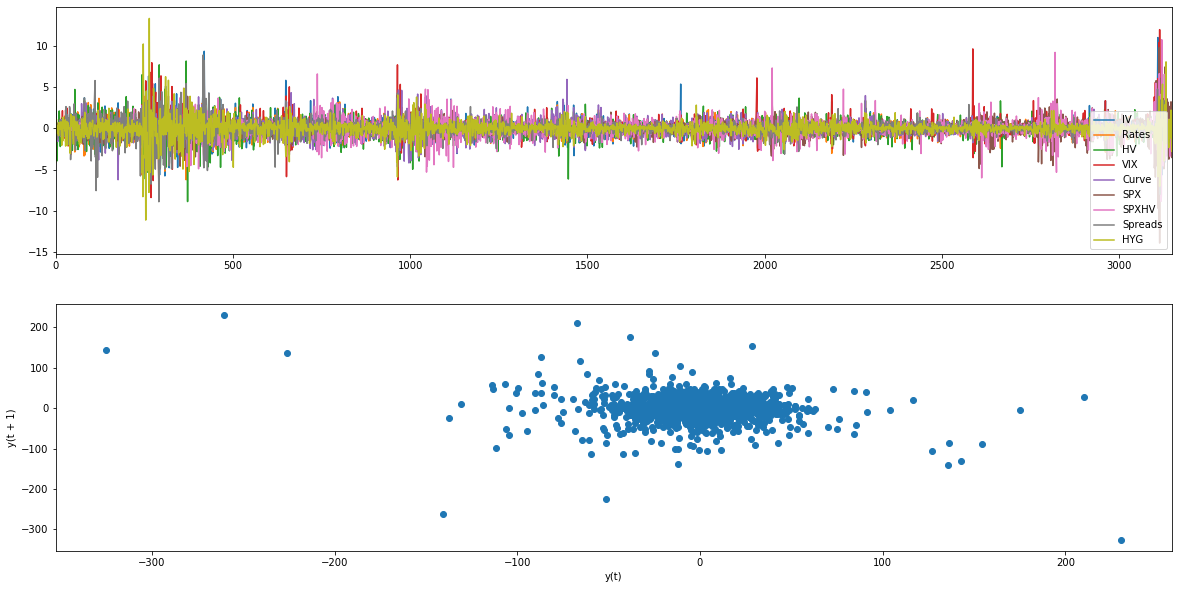

In [31]:
# Is the data Random.  Random data will not exhibit a structure in the lag plot

fig,(ax1,ax2)=plt.subplots(nrows=2, ncols=1, figsize=(20,10))
t_scaled.plot(ax=ax1) # series plot
pd.plotting.lag_plot(t) #lag plot

# Run Autocorrelation Plots on each of the Differenced Variables for All Days in the Time Series

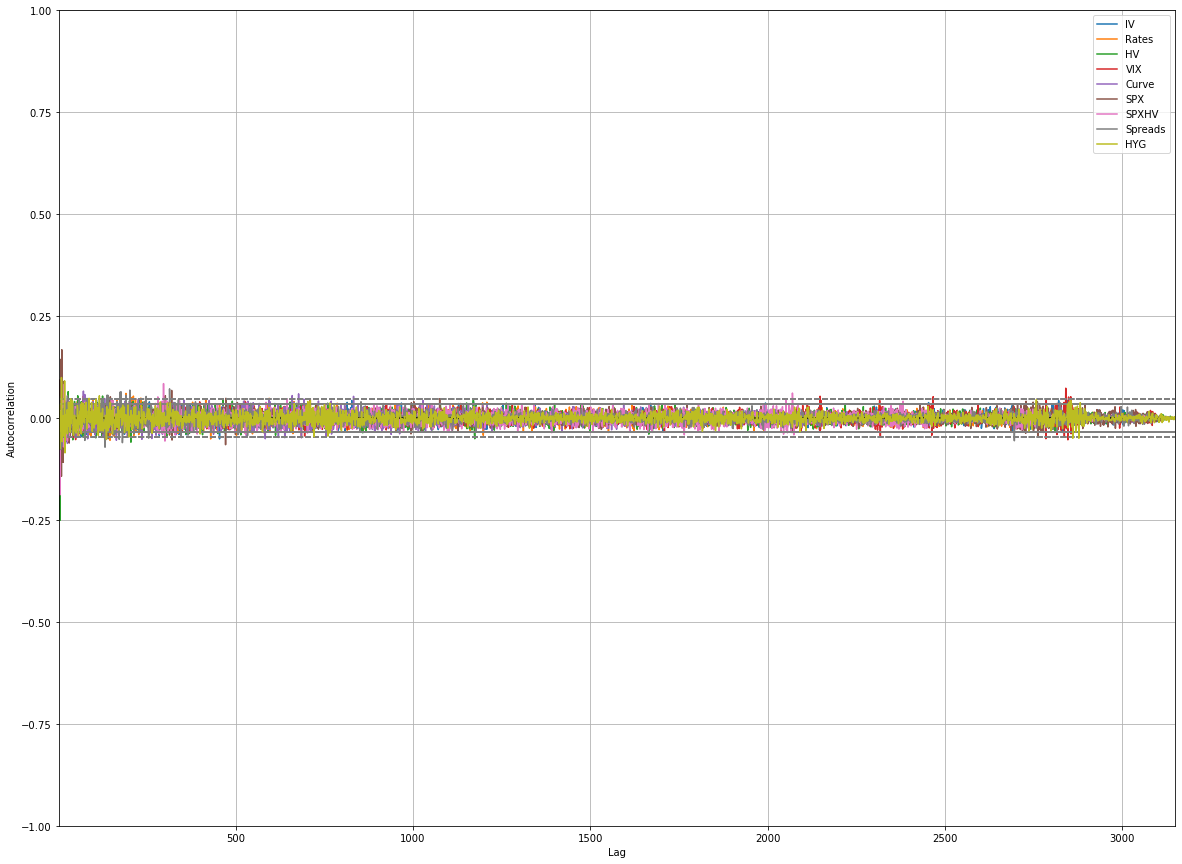

In [32]:
pd.plotting.autocorrelation_plot(t.IV, label = 'IV')
pd.plotting.autocorrelation_plot(t.Rates, label = 'Rates')
pd.plotting.autocorrelation_plot(t.HV, label = 'HV')
pd.plotting.autocorrelation_plot(t.VIX, label = 'VIX')
pd.plotting.autocorrelation_plot(t.Curve, label = 'Curve')
pd.plotting.autocorrelation_plot(t.SPX, label = 'SPX')
pd.plotting.autocorrelation_plot(t.SPXHV, label = 'SPXHV')
pd.plotting.autocorrelation_plot(t.Spreads, label = 'Spreads')
pd.plotting.autocorrelation_plot(t.HYG, label = 'HYG')
plt.rcParams["figure.figsize"] = (20,15)

# Run Autocorrelation and PACF plots for each differenced variable for 75 days

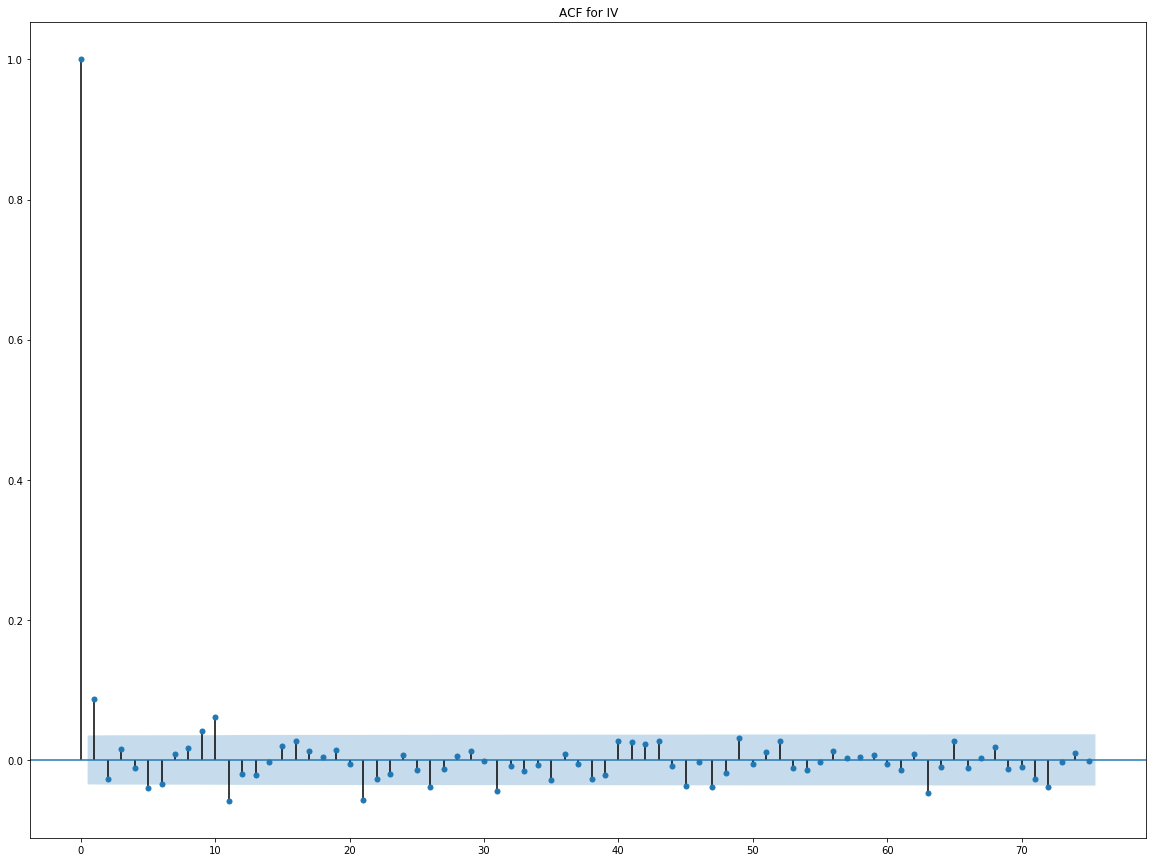

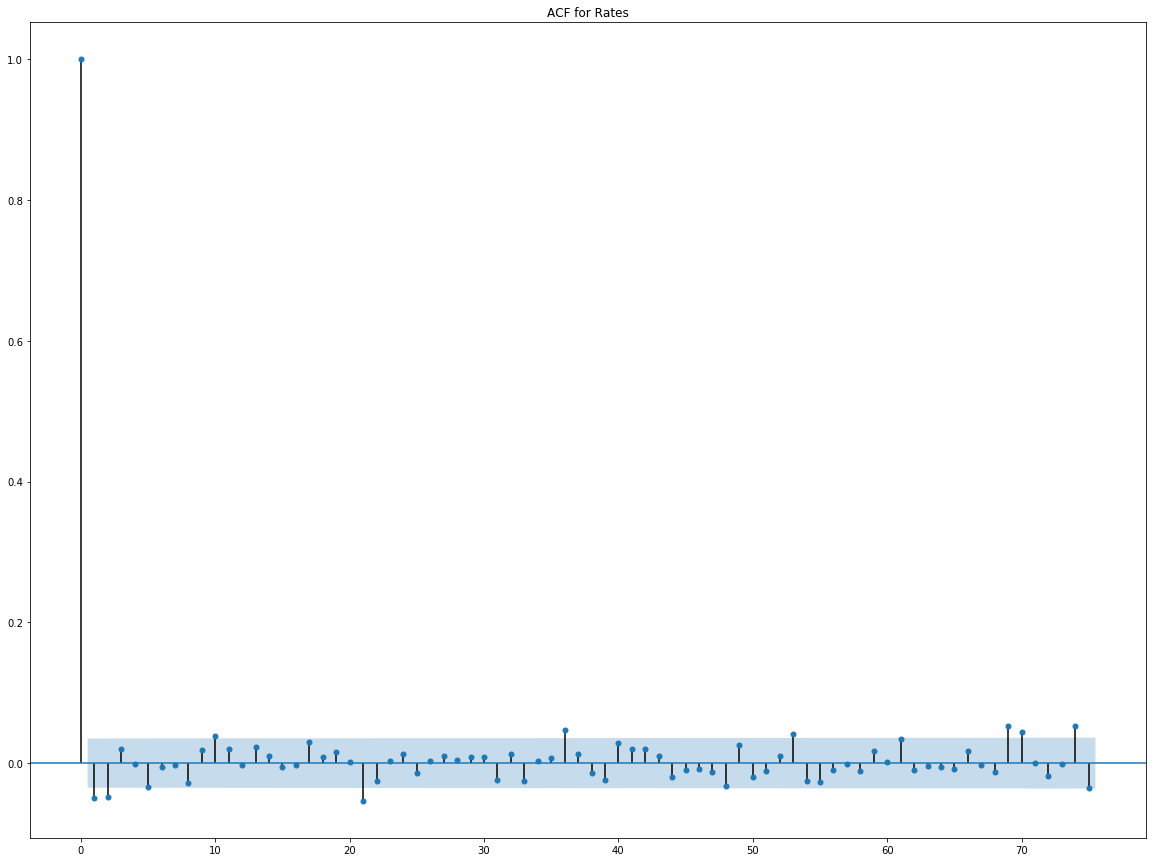

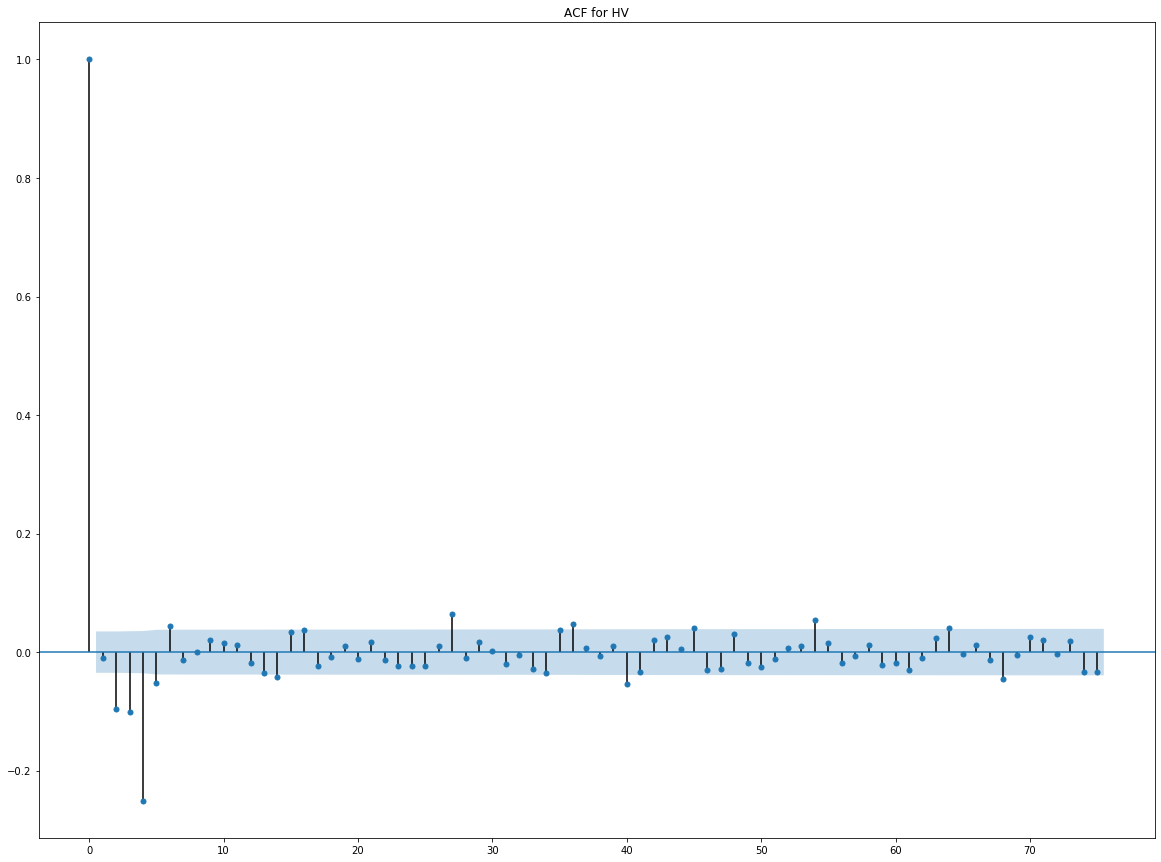

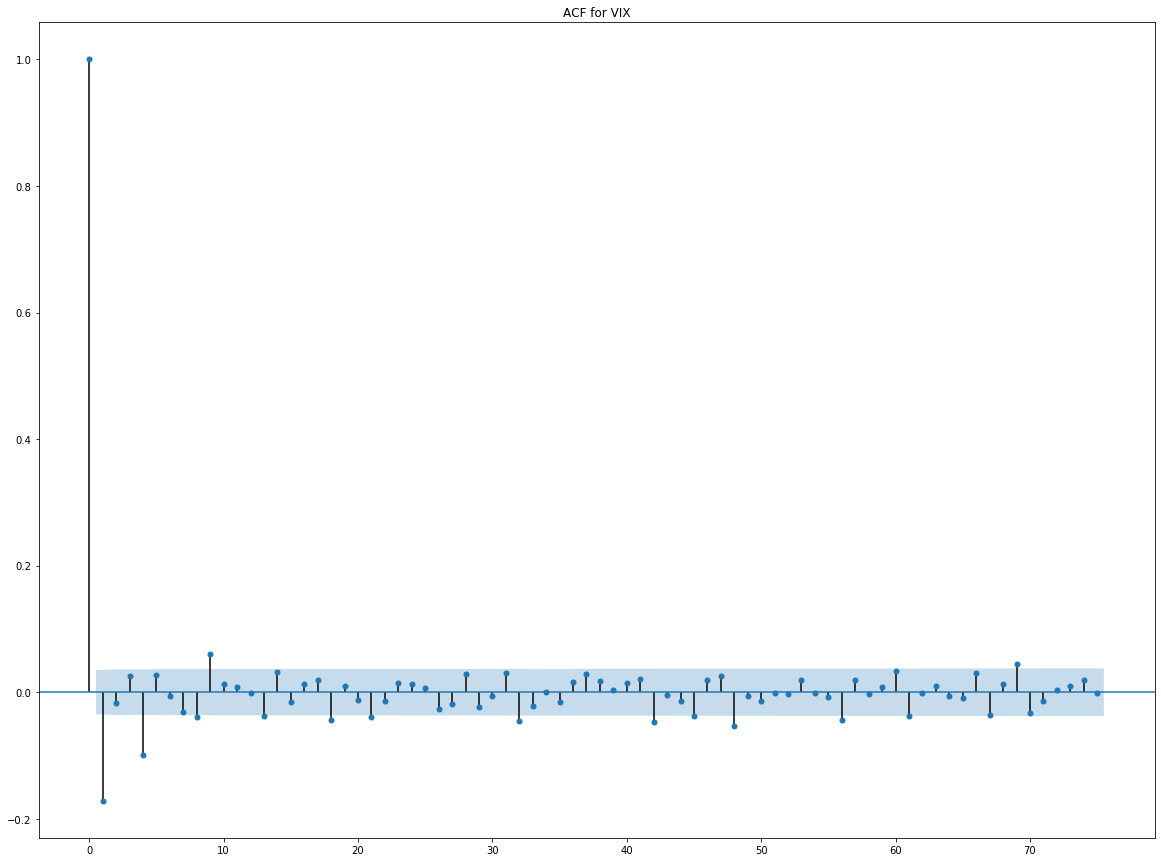

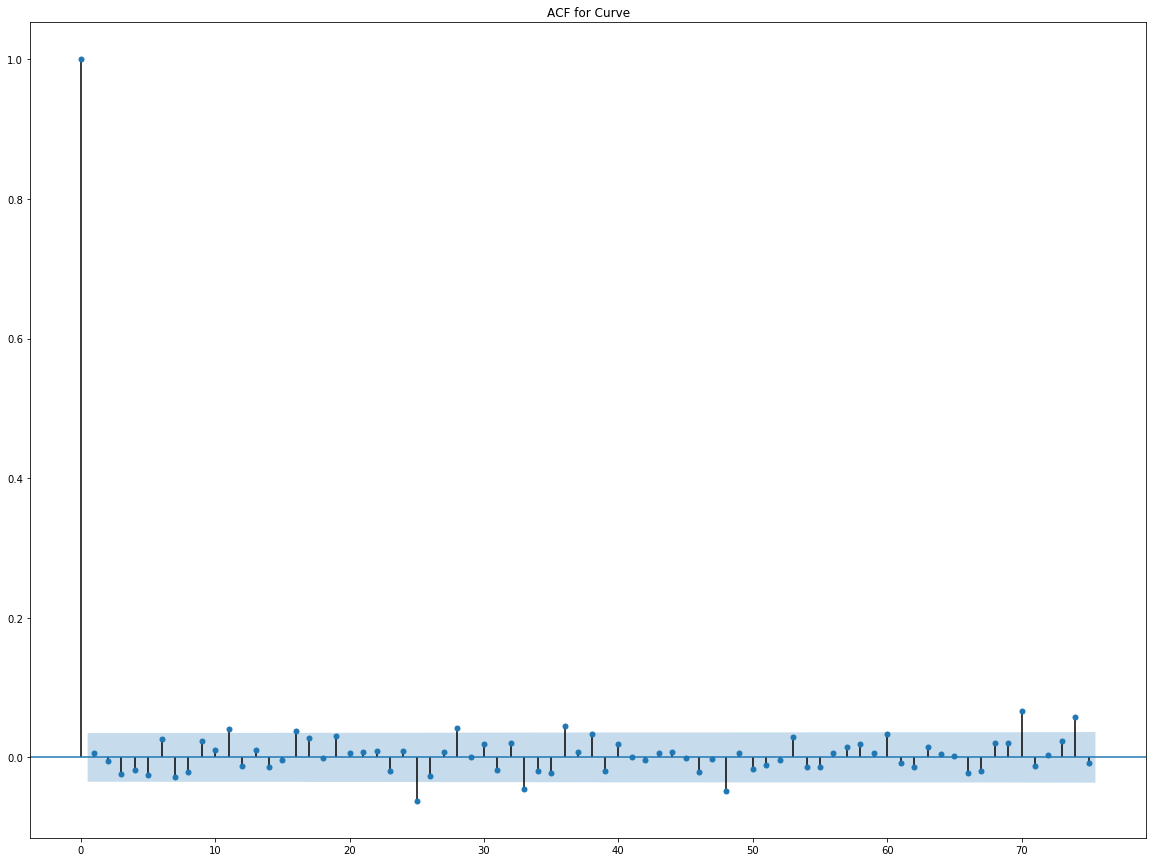

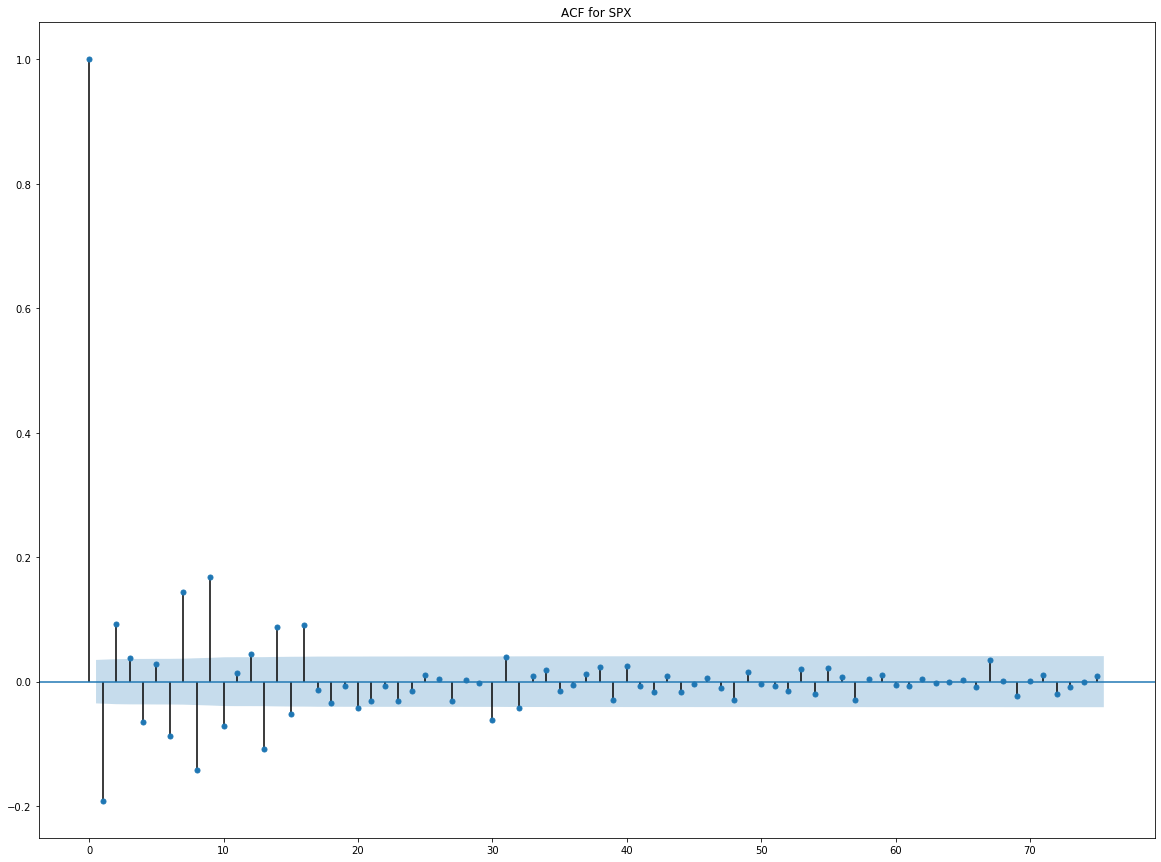

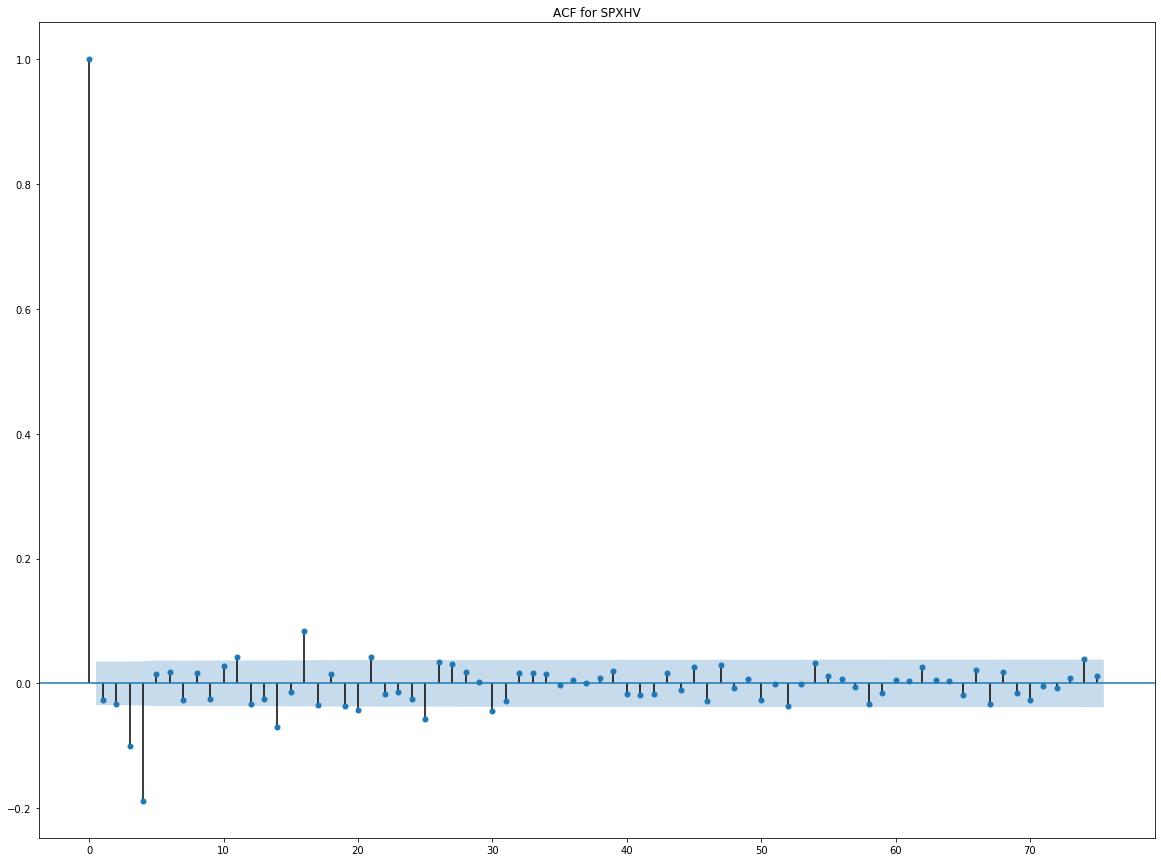

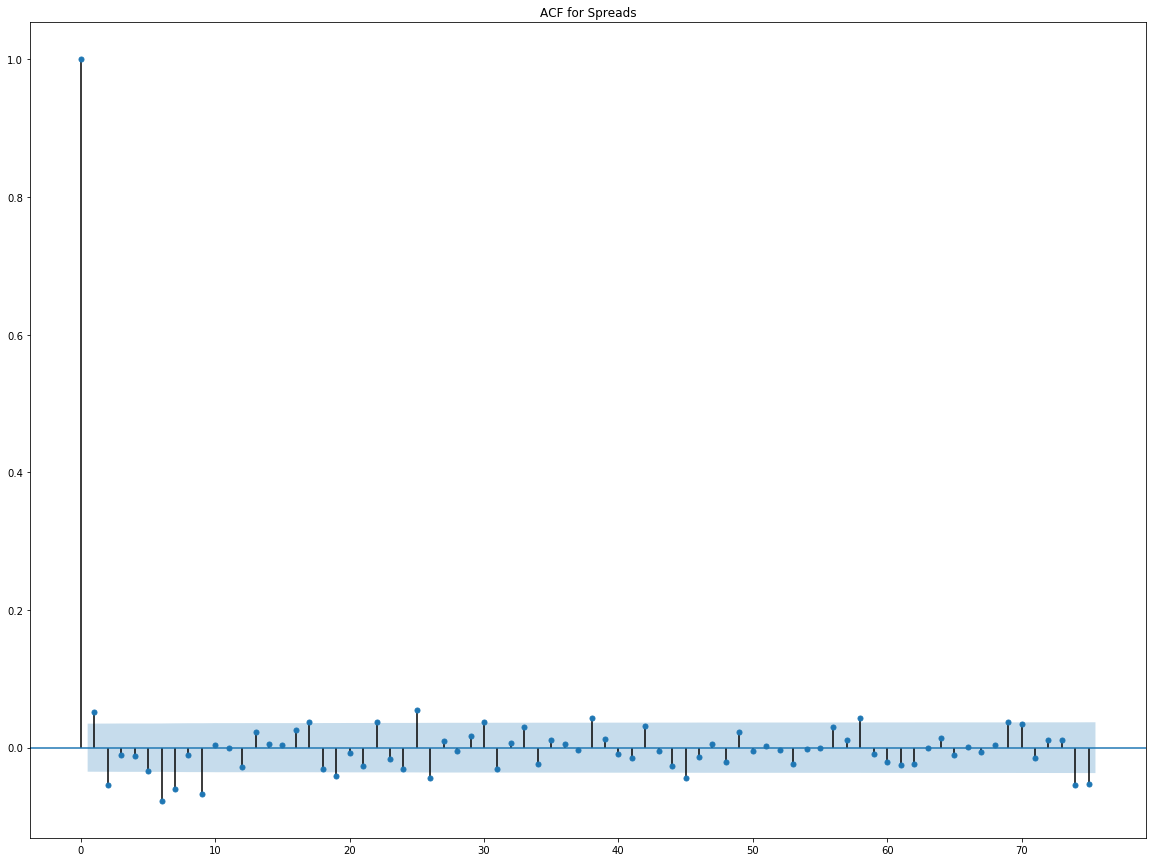

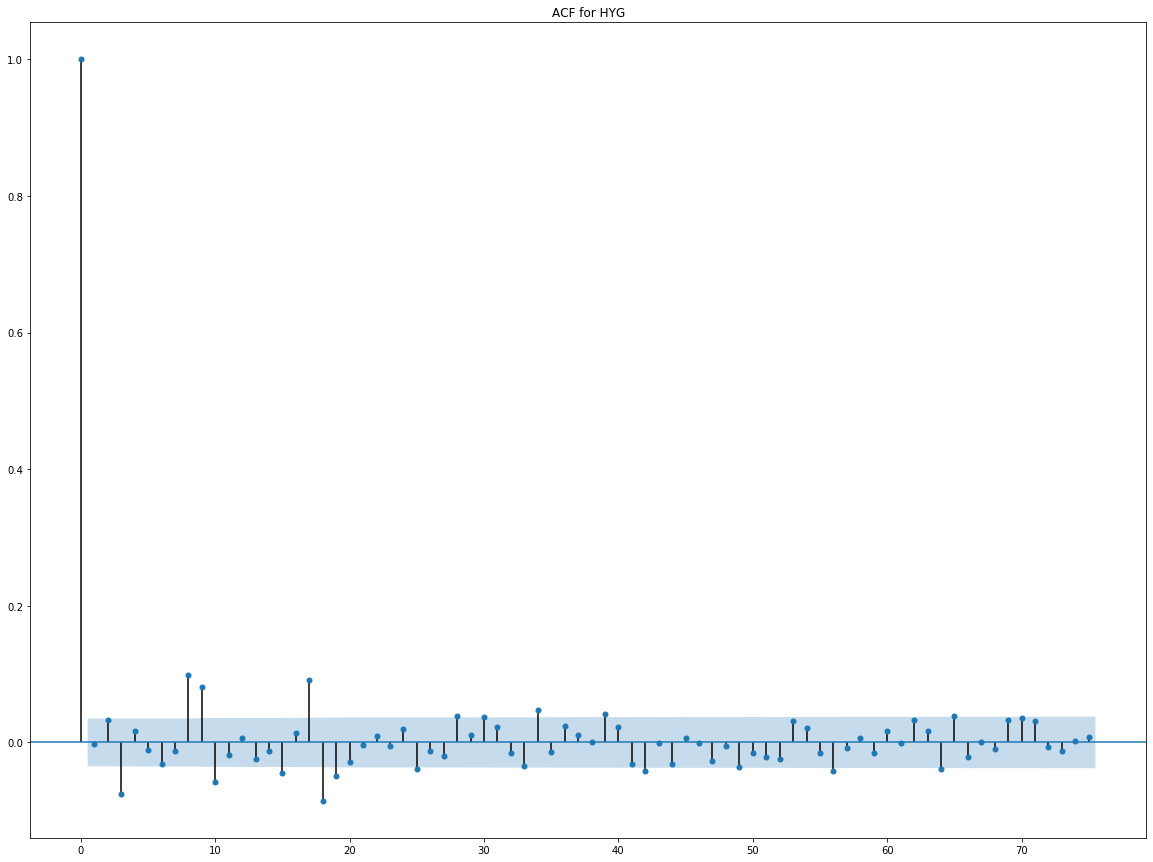

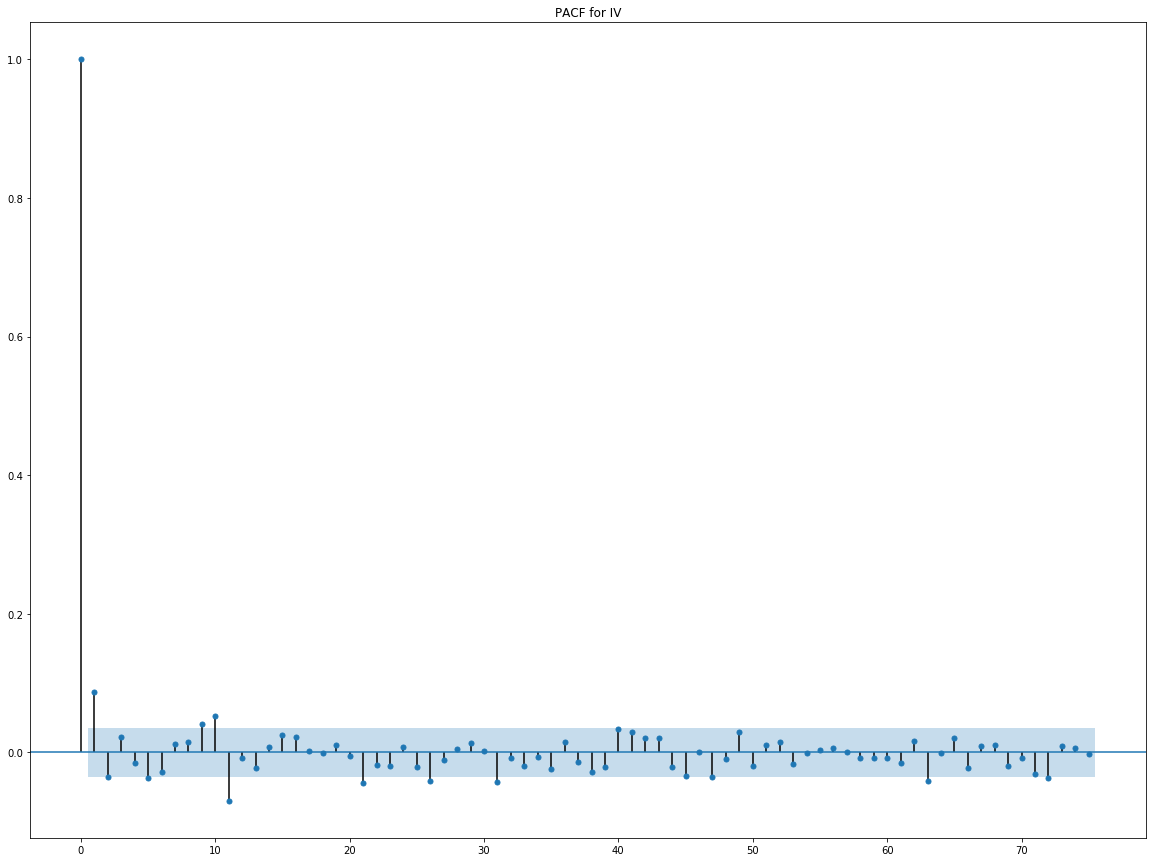

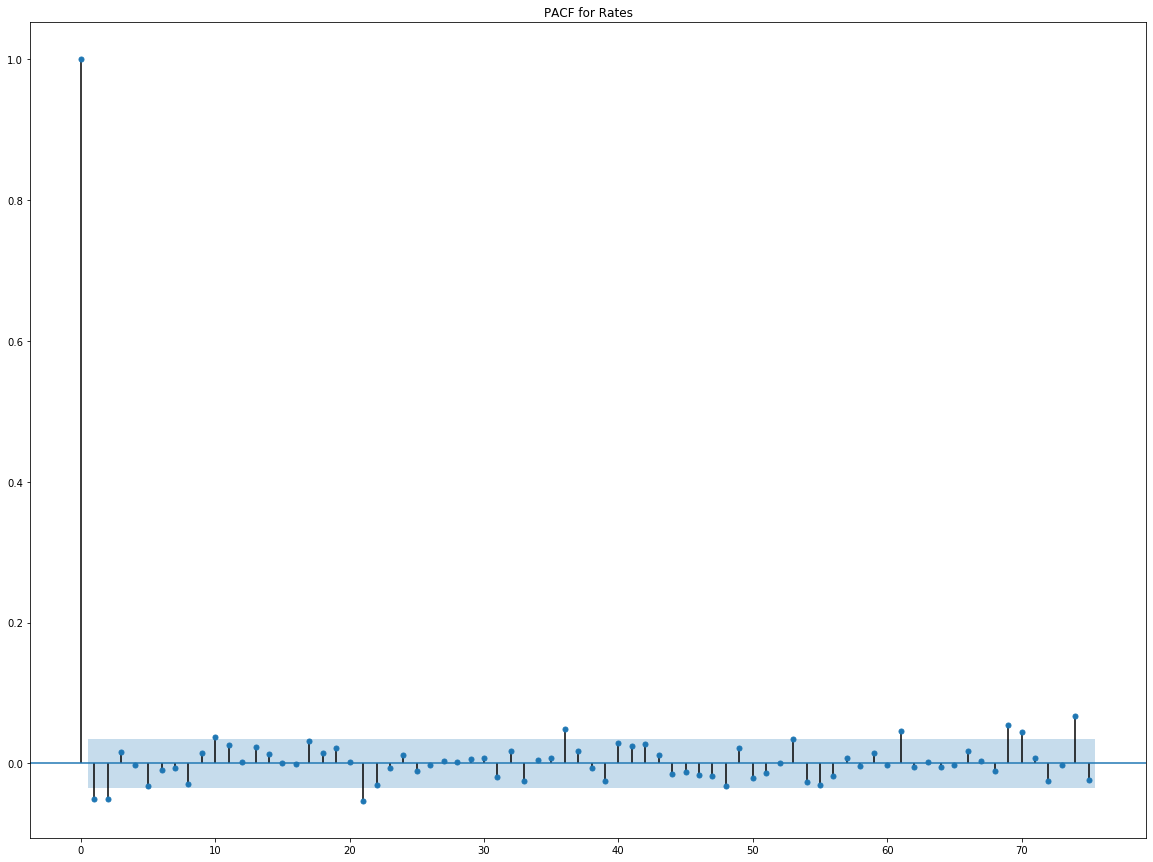

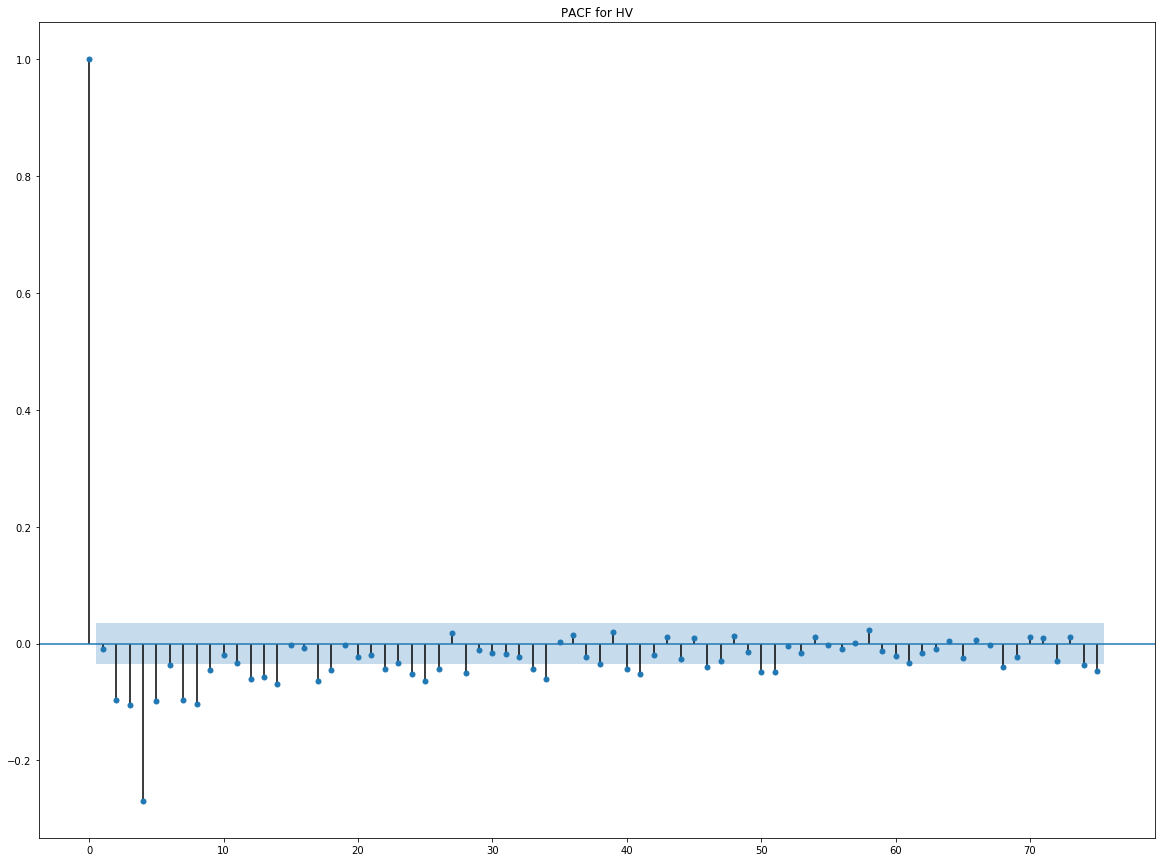

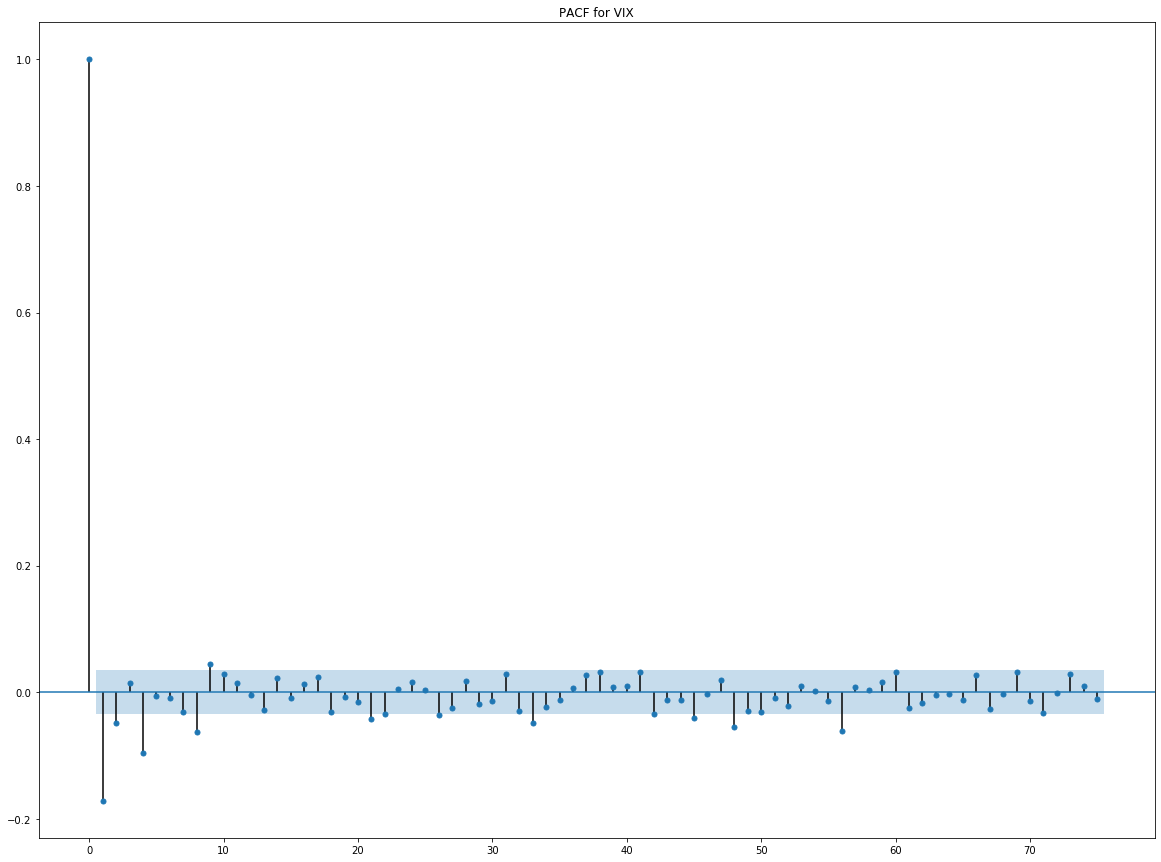

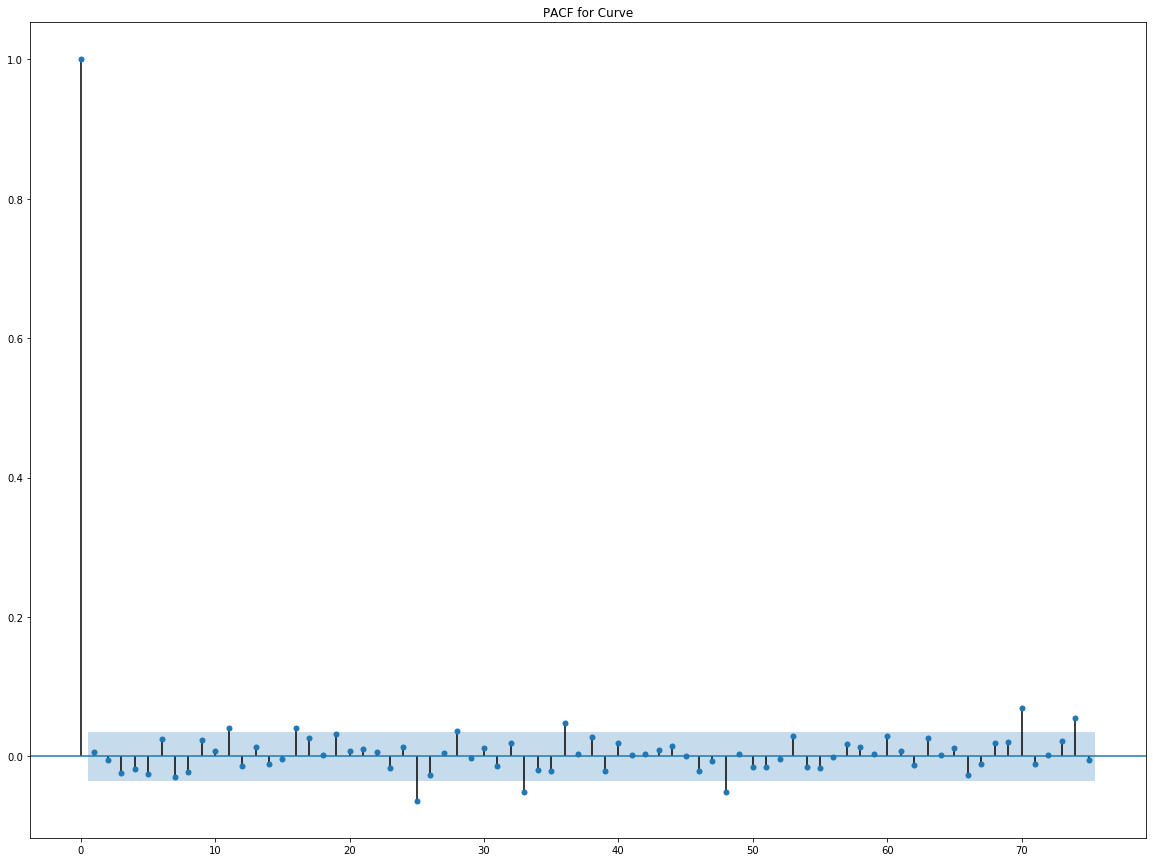

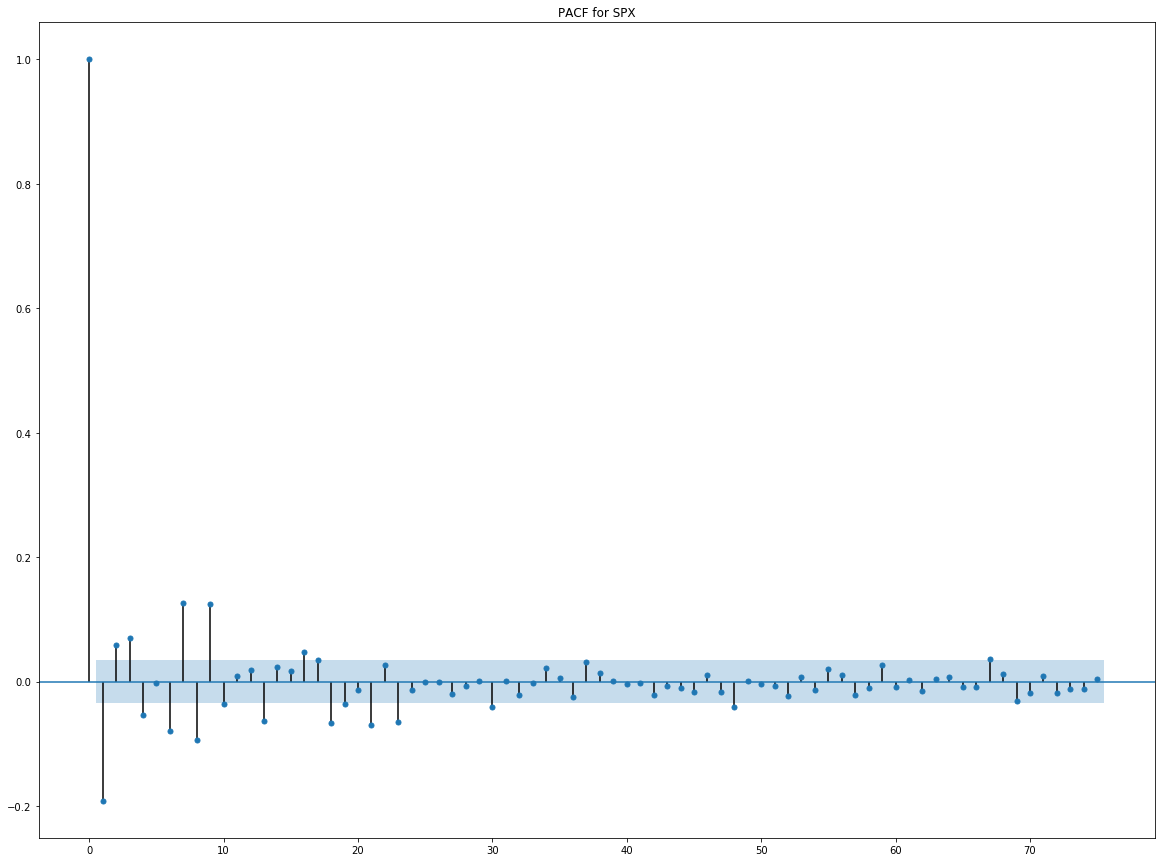

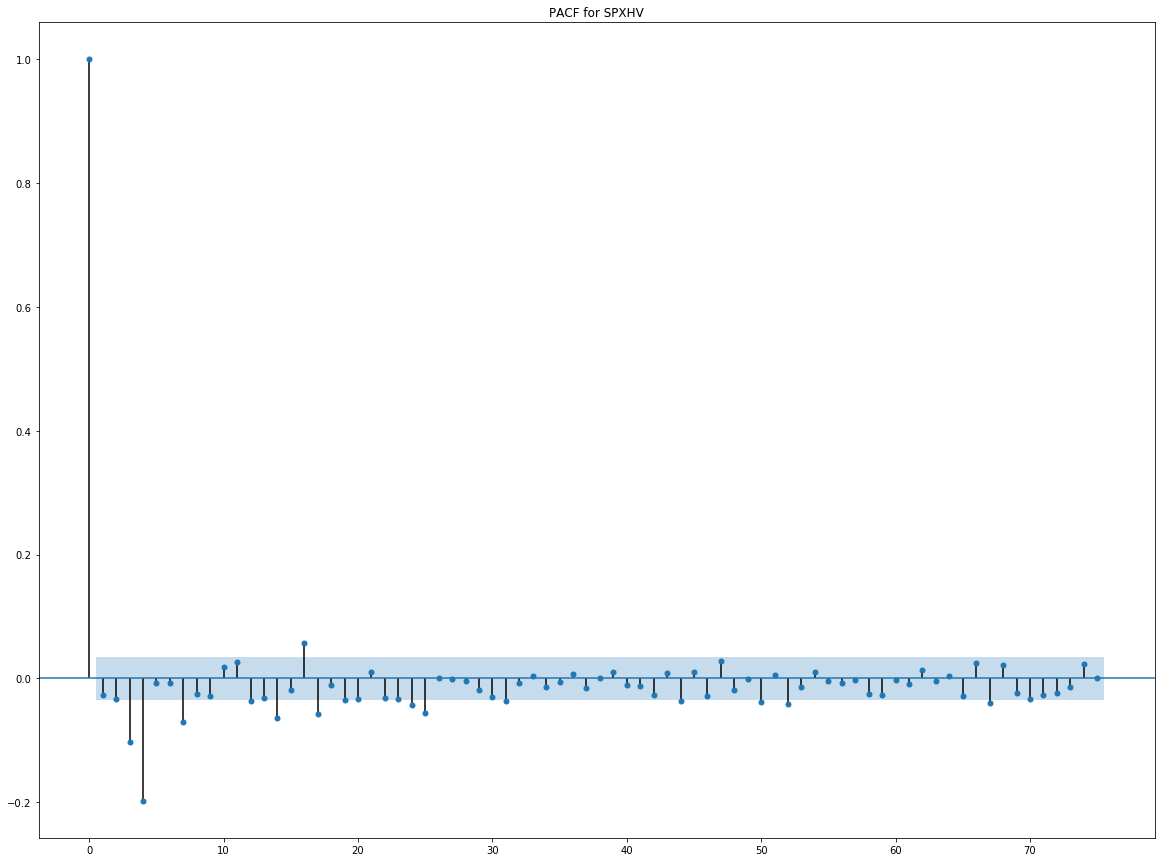

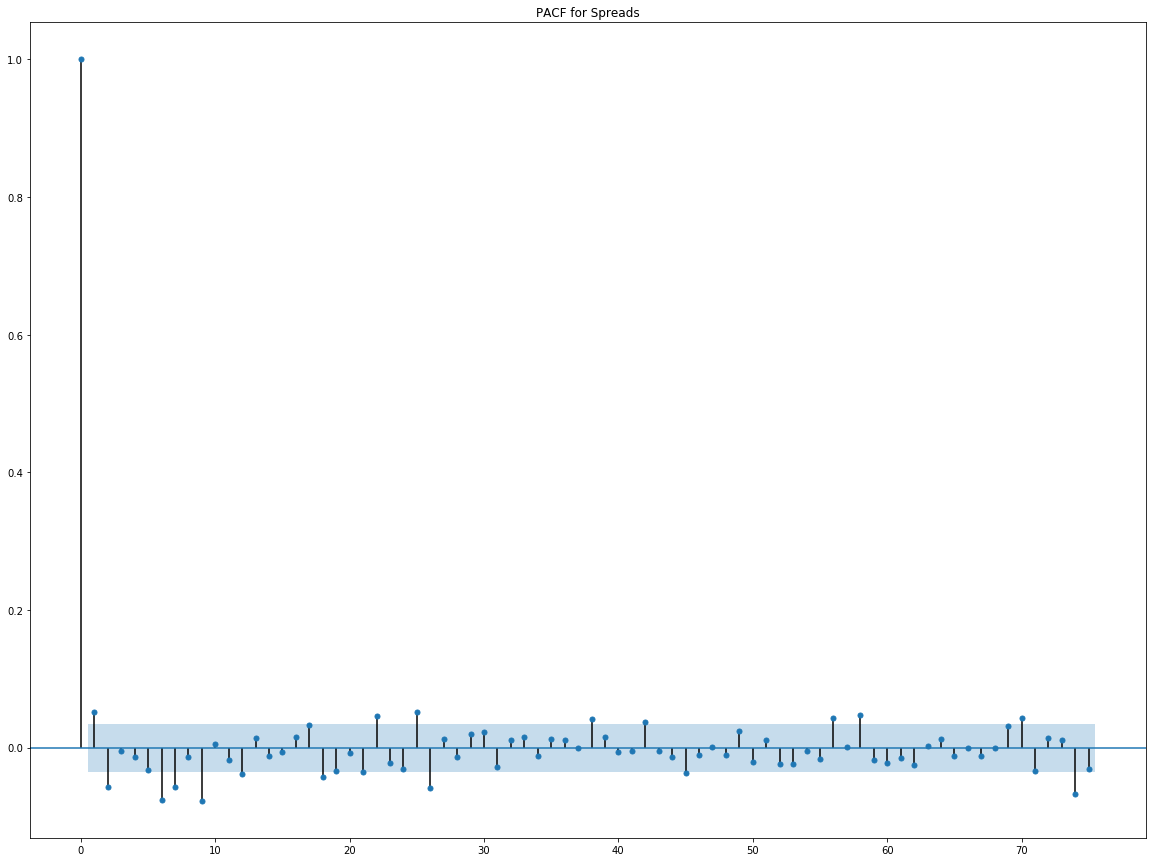

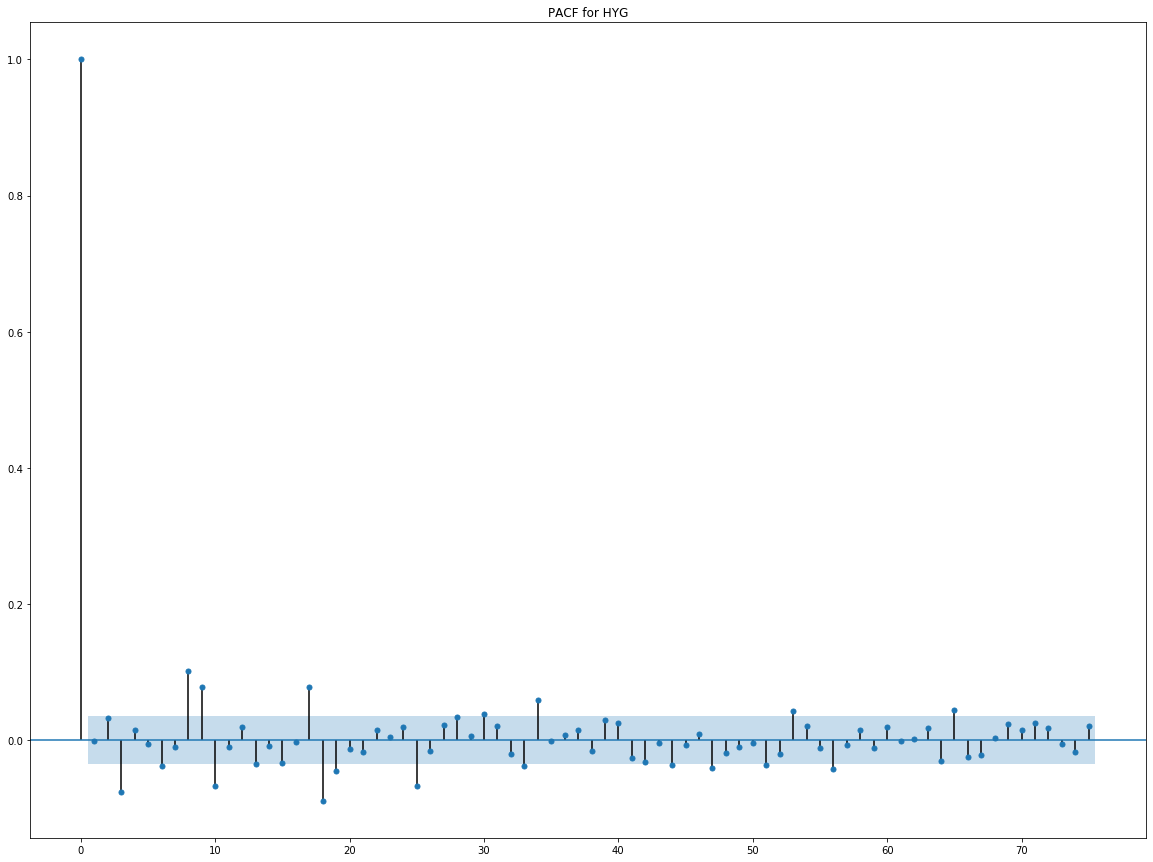

In [33]:
for i in t:
    plot_acf(t[i],lags=75)
    plt.title('ACF for %s'%i)
    
for j in t:
    plot_pacf(t[j], lags=75)
    plt.title('PACF for %s'%j)

# Run Granger Causality Tests on Every Differenced Variable

In [34]:
grangers_causation_matrix(t, variables = t.columns)

C:\Users\pjant\Miniconda3\envs\data601\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\pjant\Miniconda3\envs\data601\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\pjant\Miniconda3\envs\data601\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 11, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\pjant\Miniconda3\envs\data601\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)


,IV_x,Rates_x,HV_x,VIX_x,Curve_x,SPX_x,SPXHV_x,Spreads_x,HYG_x
IV_y,1.0,0.0001,0.0001,0.0000,0.0127,0.2947,0.0000,0.0071,0.0000
Rates_y,0.0,1.0000,0.0003,0.0000,0.0012,0.0104,0.0927,0.0049,0.0109
HV_y,0.0,0.0006,1.0000,0.0000,0.0025,0.0353,0.0058,0.1253,0.0000
VIX_y,0.0,0.0065,0.0004,1.0000,0.0002,0.0000,0.0000,0.0000,0.0000
Curve_y,0.0,0.0065,0.0127,0.0018,1.0000,0.0137,0.0182,0.0007,0.0439
SPX_y,0.0,0.0682,0.0007,0.0000,0.0211,1.0000,0.0000,0.0017,0.0018
SPXHV_y,0.0,0.2681,0.0013,0.0004,0.3807,0.0000,1.0000,0.0209,0.0057
Spreads_y,0.0,0.0000,0.0006,0.0000,0.0001,0.0000,0.0006,1.0000,0.0000
HYG_y,0.0,0.1974,0.0002,0.0000,0.0007,0.0000,0.0008,0.0000,1.0000


In [35]:
from statsmodels.tsa.stattools import grangercausalitytests
print(grangercausalitytests(t[['IV','Rates']], maxlag=30, addconst=True, verbose=True))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0012  , p=0.9727  , df_denom=3145, df_num=1
ssr based chi2 test:   chi2=0.0012  , p=0.9727  , df=1
likelihood ratio test: chi2=0.0012  , p=0.9727  , df=1
parameter F test:         F=0.0012  , p=0.9727  , df_denom=3145, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7047  , p=0.1820  , df_denom=3142, df_num=2
ssr based chi2 test:   chi2=3.4149  , p=0.1813  , df=2
likelihood ratio test: chi2=3.4130  , p=0.1815  , df=2
parameter F test:         F=1.7047  , p=0.1820  , df_denom=3142, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6831  , p=0.1685  , df_denom=3139, df_num=3
ssr based chi2 test:   chi2=5.0605  , p=0.1674  , df=3
likelihood ratio test: chi2=5.0564  , p=0.1677  , df=3
parameter F test:         F=1.6831  , p=0.1685  , df_denom=3139, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.9035  , p=0.

{1: ({'ssr_ftest': (0.001167891480994446, 0.9727402273733086, 3145.0, 1), 'ssr_chi2test': (0.0011690055269222629, 0.9727250643348644, 1), 'lrtest': (0.0011690053088386776, 0.9727250668780083, 1), 'params_ftest': (0.001167891481961316, 0.9727402273610886, 3145.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000025B8947DF60>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000025B8947D390>, array([[0., 1., 0.]])]), 2: ({'ssr_ftest': (1.7047324344345902, 0.18198915555779735, 3142.0, 2), 'ssr_chi2test': (3.414890497241028, 0.18132845048658977, 2), 'lrtest': (3.4130390438185714, 0.18149638879720767, 2), 'params_ftest': (1.704732434434367, 0.18198915555780448, 3142.0, 2.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000025B8947D6A0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000025B8947DC88>, array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])]), 3: ({'ss

# Run Cointegration Tests for Each of the Differenced Variables

In [36]:
cointegration_test(t)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
IV     ::  5889.51   > 179.5199  =>   True
Rates  ::  4880.57   > 143.6691  =>   True
HV     ::  3888.28   > 111.7797  =>   True
VIX    ::  3181.75   > 83.9383   =>   True
Curve  ::  2527.92   > 60.0627   =>   True
SPX    ::  1939.21   > 40.1749   =>   True
SPXHV  ::  1377.27   > 24.2761   =>   True
Spreads ::  892.86    > 12.3212   =>   True
HYG    ::  425.85    > 4.1296    =>   True


# Run Dickey-Fuller Tests on the Differenced Data to Check for Stationarity

In [37]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in t.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "IV" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -16.7799
 No. Lags Chosen       = 10
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Rates" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -42.7513
 No. Lags Chosen       = 1
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "HV" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05


# Test for best Lags to Use

In [38]:
model = VAR(t)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -2.8734901186827226
BIC :  -2.7003938560212375
FPE :  0.05650139638527392
HQIC:  -2.8113801838880055 

Lag Order = 2
AIC :  -2.9537969265224953
BIC :  -2.6248267843559834
FPE :  0.05214142158690295
HQIC:  -2.835754838355844 

Lag Order =

C:\Users\pjant\Miniconda3\envs\data601\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 3
AIC :  -3.0233916321250645
BIC :  -2.538464885439816
FPE :  0.04863618869393614
HQIC:  -2.849385897675443 

Lag Order = 4
AIC :  -3.2060396419570036
BIC :  -2.565073494636876
FPE :  0.04051715269700123
HQIC:  -2.976038740452319 

Lag Order = 5
AIC :  -3.2347777177193153
BIC :  -2.437689302461896
FPE :  0.03936969491911142
HQIC:  -2.948750100492944 

Lag Order = 6
AIC :  -3.266861860608111
BIC :  -2.313568238840756
FPE :  0.038127109942416915
HQIC:  -2.924775951065383 

Lag Order = 7
AIC :  -3.3279594302076183
BIC :  -2.2183775920033644
FPE :  0.03586803715431849
HQIC:  -2.929783623792242 

Lag Order = 8
AIC :  -3.3850152401090754
BIC :  -2.1190621041024245
FPE :  0.03387967863276676
HQIC:  -2.930717904269516 

Lag Order = 9
AIC :  -3.4370786956941153
BIC :  -2.014671108996696
FPE :  0.03216193094246716
HQIC:  -2.9266281698499235 



In [39]:
x = model.select_order(maxlags=20)
x.summary()

,AIC,BIC,FPE,HQIC
0,-2.679,-2.662,0.06864,-2.673
1,-2.861,-2.687*,0.05719,-2.799
2,-2.944,-2.613,0.05266,-2.825
3,-3.015,-2.528,0.04905,-2.840
4,-3.199,-2.555,0.04080,-2.968*
5,-3.226,-2.426,0.03972,-2.939
6,-3.258,-2.301,0.03848,-2.914
7,-3.321,-2.207,0.03612,-2.921
8,-3.380,-2.110,0.03403,-2.925
9,-3.434,-2.007,0.03227,-2.922


# Fit the Model

In [40]:
model_fitted = model.fit(20)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 18, May, 2020
Time:                     21:31:50
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                  -0.416654
Nobs:                     3129.00    HQIC:                  -2.43534
Log likelihood:          -32751.4    FPE:                  0.0283138
AIC:                     -3.56557    Det(Omega_mle):       0.0170686
--------------------------------------------------------------------
Results for equation IV
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.035383         0.051276           -0.690           0.490
L1.IV               0.033679         0.020275            1.661           0.097
L1.Rates            3.433889         1.284603            2.673         

# Run Durbin Watson Stats on Fitted Model

In [41]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(t.columns, out):
    print((col), ':', round(val, 2))

IV : 2.01
Rates : 2.0
HV : 2.0
VIX : 2.0
Curve : 2.0
SPX : 1.99
SPXHV : 2.0
Spreads : 2.0
HYG : 1.99


# Run the Forecasts

In [42]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = t.values[-lag_order:]
forecast_input

20


array([[ 1.54500000e+00,  6.41000000e-02,  4.98522575e-01,
        -1.56000000e+00,  4.22000000e-02,  1.75030000e+02,
         3.40743216e+01, -8.70000000e-01,  1.79000000e+00],
       [ 2.55000000e+00,  5.30000000e-02, -3.60000000e-02,
         1.46000000e+00,  2.68000000e-02, -4.27000000e+00,
        -1.99142798e+01,  1.25000000e+00,  0.00000000e+00],
       [ 5.44500000e+00,  5.60000000e-02, -1.73000000e-01,
        -3.35000000e+00,  6.30000000e-02,  9.05700000e+01,
         1.30924691e+00, -4.30000000e-01,  1.96000000e+00],
       [-8.28600000e-01, -1.61000000e-02,  8.90000000e-02,
        -1.68000000e+00,  3.09000000e-02,  3.98400000e+01,
        -1.19724930e+01,  2.43000000e+00,  5.06000000e+00],
       [ 6.78600000e-01, -1.20000000e-03, -4.00000000e-03,
         0.00000000e+00, -2.70000000e-03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 6.10000000e-01,  3.46000000e-02, -6.50000000e-02,
        -5.00000000e-01,  3.48000000e-02, -2.819000

# Test the Model

In [43]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = t.values[-lag_order:]
forecast_input

20


array([[ 1.54500000e+00,  6.41000000e-02,  4.98522575e-01,
        -1.56000000e+00,  4.22000000e-02,  1.75030000e+02,
         3.40743216e+01, -8.70000000e-01,  1.79000000e+00],
       [ 2.55000000e+00,  5.30000000e-02, -3.60000000e-02,
         1.46000000e+00,  2.68000000e-02, -4.27000000e+00,
        -1.99142798e+01,  1.25000000e+00,  0.00000000e+00],
       [ 5.44500000e+00,  5.60000000e-02, -1.73000000e-01,
        -3.35000000e+00,  6.30000000e-02,  9.05700000e+01,
         1.30924691e+00, -4.30000000e-01,  1.96000000e+00],
       [-8.28600000e-01, -1.61000000e-02,  8.90000000e-02,
        -1.68000000e+00,  3.09000000e-02,  3.98400000e+01,
        -1.19724930e+01,  2.43000000e+00,  5.06000000e+00],
       [ 6.78600000e-01, -1.20000000e-03, -4.00000000e-03,
         0.00000000e+00, -2.70000000e-03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 6.10000000e-01,  3.46000000e-02, -6.50000000e-02,
        -5.00000000e-01,  3.48000000e-02, -2.819000

In [44]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df_test.index[-nobs:], columns=t.columns + '_1d')
df_forecast

,IV_1d,Rates_1d,HV_1d,VIX_1d,Curve_1d,SPX_1d,SPXHV_1d,Spreads_1d,HYG_1d
Date,,,,,,,,,
2020-05-04,3.756736,0.043812,-0.139278,-1.261867,0.038270,4.608927,2.636987,-0.633238,0.136558
2020-05-05,3.198666,0.001904,-0.155174,0.796813,0.005467,-0.742995,-1.702820,0.797620,-0.393393
2020-05-06,0.008221,-0.044874,0.257624,1.454570,-0.017551,-22.476749,0.784975,1.415049,-0.847313
2020-05-07,-0.664874,0.022925,0.089959,-1.477498,0.000791,8.672598,-3.725152,-0.377642,-0.370194
2020-05-08,0.001708,0.018579,0.079652,-0.778546,0.030550,30.459260,-0.536663,0.140993,0.520277


In [45]:
forecast_input.shape, nobs, fc.shape

((20, 9), 5, (5, 9))

In [46]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
#        if second_diff:
#            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [47]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)       
df_results.loc[:, ['IV_forecast', 'Rates_forecast', 'HV_forecast', 'VIX_forecast', 'Curve_forecast',
                   'SPX_forecast', 'SPXHV_forecast', 'CDXHY_forecast','Spreads_forecast','HYG_forecast']]

C:\Users\pjant\Miniconda3\envs\data601\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,IV_forecast,Rates_forecast,HV_forecast,VIX_forecast,Curve_forecast,SPX_forecast,SPXHV_forecast,CDXHY_forecast,Spreads_forecast,HYG_forecast
Date,,,,,,,,,,
2020-05-04,63.906736,0.663312,0.377830,35.928133,0.333770,2835.318927,39.189256,NaN,-0.133238,78.816558
2020-05-05,67.105402,0.665216,0.222656,36.724946,0.339237,2834.575932,37.486436,NaN,0.664382,78.423164
2020-05-06,67.113623,0.620342,0.480280,38.179516,0.321686,2812.099183,38.271410,NaN,2.079431,77.575851
2020-05-07,66.448748,0.643267,0.570239,36.702018,0.322477,2820.771782,34.546258,NaN,1.701789,77.205657
2020-05-08,66.450456,0.661846,0.649890,35.923472,0.353028,2851.231042,34.009595,NaN,1.842782,77.725934


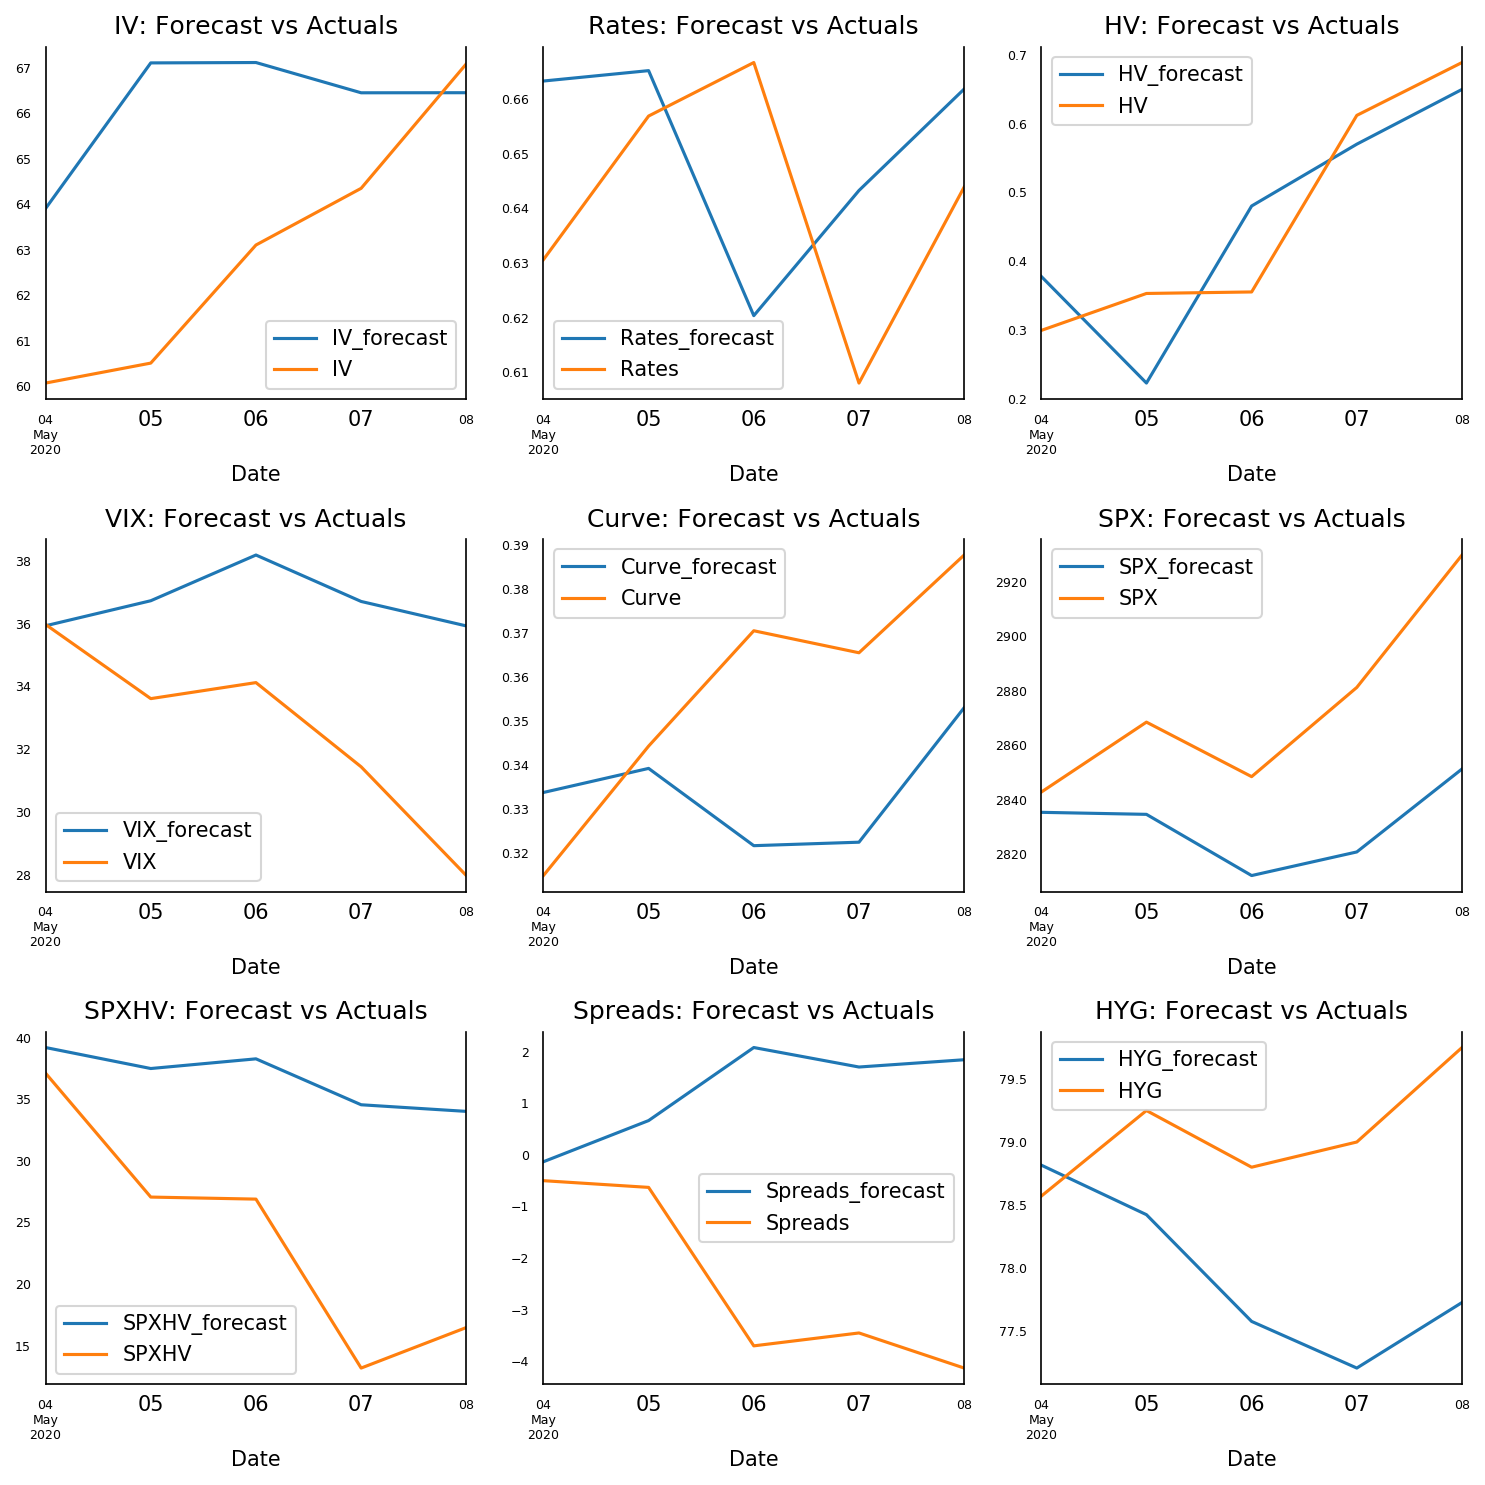

In [48]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/3), ncols=3, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# Run the Model Accuracy Statistics

In [49]:
# mape is mean absolute percentage error (errors / values)
# me is margin of error (a statistic expressing the amount of random sampling error in the results of a survey)
# mae is mean absolute error
# mpe is mean percentage error
# rmse is root mean squared error
# corr is correlation between the forecast and the actual values

from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: IV')
accuracy_prod = forecast_accuracy(df_results['IV_forecast'].values, df_test['IV'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: Rates')
accuracy_prod = forecast_accuracy(df_results['Rates_forecast'].values, df_test['Rates'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: HV')
accuracy_prod = forecast_accuracy(df_results['HV_forecast'].values, df_test['HV'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: VIX')
accuracy_prod = forecast_accuracy(df_results['VIX_forecast'].values, df_test['VIX'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: Curve')
accuracy_prod = forecast_accuracy(df_results['Curve_forecast'].values, df_test['Curve'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: SPX')
accuracy_prod = forecast_accuracy(df_results['SPX_forecast'].values, df_test['SPX'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: SPXHV')
accuracy_prod = forecast_accuracy(df_results['SPXHV_forecast'].values, df_test['SPXHV'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: Spreads')
accuracy_prod = forecast_accuracy(df_results['Spreads_forecast'].values, df_test['Spreads'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))
    
print('\nForecast Accuracy of: HYG')
accuracy_prod = forecast_accuracy(df_results['HYG_forecast'].values, df_test['HYG'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: IV
mape :  0.0557
me :  3.1808
mae :  3.4347
mpe :  0.0519
rmse :  3.9772
corr :  0.3864
minmax :  0.0518

Forecast Accuracy of: Rates
mape :  0.044
me :  0.0096
mae :  0.0281
mpe :  0.0162
rmse :  0.0312
corr :  -0.2283
minmax :  0.0427

Forecast Accuracy of: HV
mape :  0.2219
me :  -0.0015
mae :  0.083
mpe :  0.024
rmse :  0.0918
corr :  0.8224
minmax :  0.1926

Forecast Accuracy of: VIX
mape :  0.1328
me :  4.0676
mae :  4.0844
mpe :  0.1324
rmse :  4.8368
corr :  0.2896
minmax :  0.1114

Forecast Accuracy of: Curve
mape :  0.0827
me :  -0.0225
mae :  0.0301
mpe :  -0.0587
rmse :  0.0341
corr :  0.1813
minmax :  0.082

Forecast Accuracy of: SPX
mape :  0.015
me :  -43.3186
mae :  43.3186
mpe :  -0.015
rmse :  49.688
corr :  0.6631
minmax :  0.015

Forecast Accuracy of: SPXHV
mape :  0.7094
me :  12.5542
mae :  12.5542
mpe :  0.7094
rmse :  14.1835
corr :  0.9483
minmax :  0.3524

Forecast Accuracy of: Spreads
mape :  1.4579
me :  3.713
mae :  3.713
mpe :  -1.45

# Next n Days Predictions

In [50]:
bd = pd.tseries.offsets.BusinessDay(n = nobs)
bd

<5 * BusinessDays>

In [51]:
ed = bd + df.index[-1]
fc_dates = pd.bdate_range(pd.tseries.offsets.BusinessDay(1) + df.index[-1],ed)
fc_dates = fc_dates[0:nobs]
fc_dates

DatetimeIndex(['2020-05-11', '2020-05-12', '2020-05-13', '2020-05-14',
               '2020-05-15'],
              dtype='datetime64[ns]', freq='B')

In [56]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=fc_dates, columns=df.columns + '_1d')
df_forecast

,IV_1d,Rates_1d,HV_1d,VIX_1d,Curve_1d,SPX_1d,SPXHV_1d,Spreads_1d,HYG_1d
2020-05-11,3.756736,0.043812,-0.139278,-1.261867,0.038270,4.608927,2.636987,-0.633238,0.136558
2020-05-12,3.198666,0.001904,-0.155174,0.796813,0.005467,-0.742995,-1.702820,0.797620,-0.393393
2020-05-13,0.008221,-0.044874,0.257624,1.454570,-0.017551,-22.476749,0.784975,1.415049,-0.847313
2020-05-14,-0.664874,0.022925,0.089959,-1.477498,0.000791,8.672598,-3.725152,-0.377642,-0.370194
2020-05-15,0.001708,0.018579,0.079652,-0.778546,0.030550,30.459260,-0.536663,0.140993,0.520277


In [60]:
df_results = invert_transformation(df, df_forecast, second_diff=False)       
df_results = df_results.loc[:, ['IV_forecast', 'Rates_forecast', 'HV_forecast', 'VIX_forecast', 'Curve_forecast',
                   'SPX_forecast', 'SPXHV_forecast','Spreads_forecast','HYG_forecast']]

df_lastrow = df.iloc[[-1]]
df_lastrow.columns = df_results.columns

df_results = pd.concat([df_lastrow, df_results])
df_results

df_results

,IV_forecast,Rates_forecast,HV_forecast,VIX_forecast,Curve_forecast,SPX_forecast,SPXHV_forecast,Spreads_forecast,HYG_forecast
2020-05-08,67.085400,0.643900,0.689029,27.980000,0.387700,2929.800000,16.478790,-4.130000,79.750000
2020-05-11,70.842136,0.687712,0.549751,26.718133,0.425970,2934.408927,19.115777,-4.763238,79.886558
2020-05-12,74.040802,0.689616,0.394577,27.514946,0.431437,2933.665932,17.412957,-3.965618,79.493164
2020-05-13,74.049023,0.644742,0.652201,28.969516,0.413886,2911.189183,18.197932,-2.550569,78.645851
2020-05-14,73.384148,0.667667,0.742160,27.492018,0.414677,2919.861782,14.472780,-2.928211,78.275657
2020-05-15,73.385856,0.686246,0.821811,26.713472,0.445228,2950.321042,13.936117,-2.787218,78.795934


In [64]:
from datetime import datetime

directory = (r'c:/Users/pjant/Trading/Market Price Prediction Results/')

#csv_file = 'daily predictions from ' + str(datetime.now().strftime('%Y%m%d'))+'.csv'
csv_file = 'daily predictions from 20200508.csv'
df_results.to_csv(directory + csv_file)

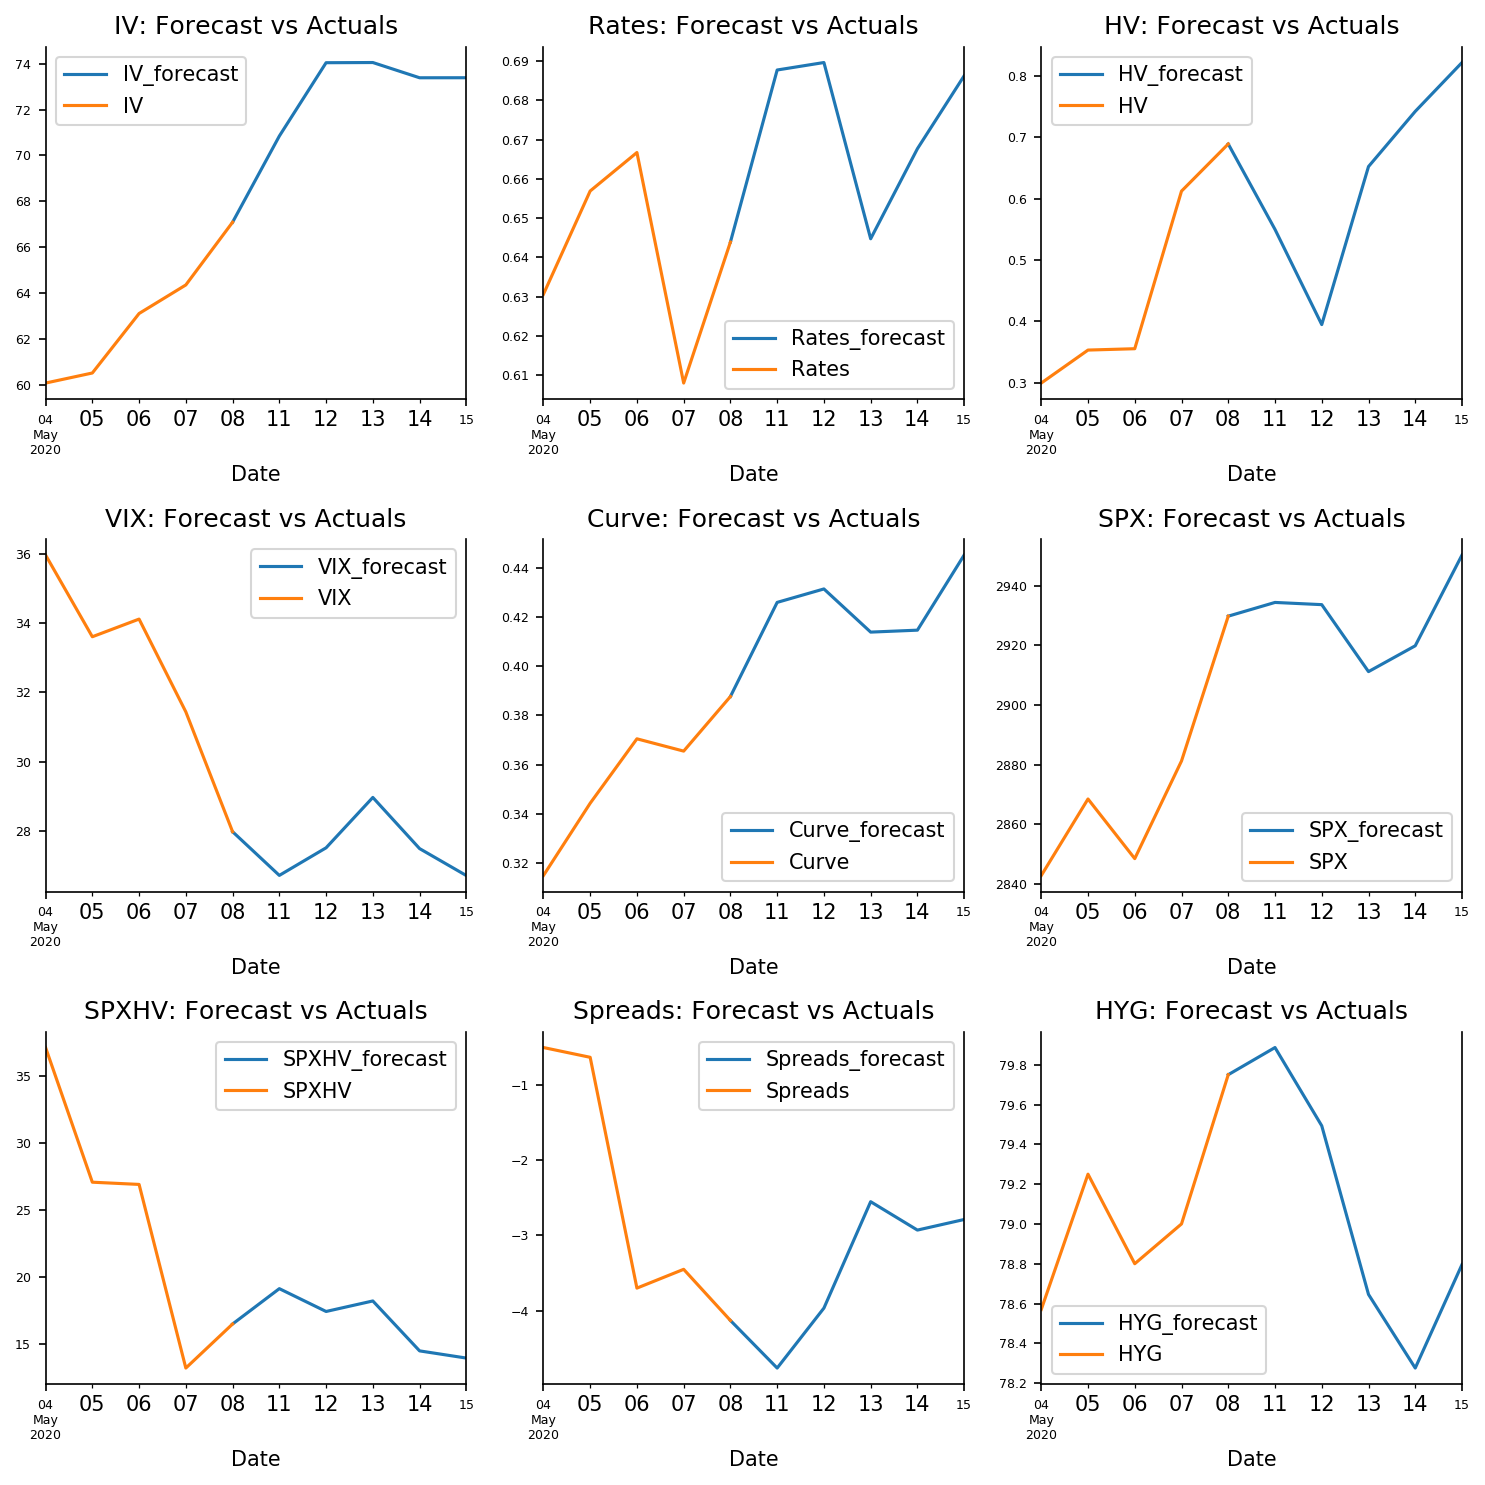

In [62]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/3), ncols=3, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();